In [1]:
import os
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("dark", 10)
from PIL import Image

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.preprocessing import image
from keras.applications import VGG16, ResNet50
from keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from keras.layers import Dense, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras_tqdm import TQDMNotebookCallback

from keras.models import load_model

Using TensorFlow backend.


In [2]:
image_dir='images' #the directory containing images
image_list='info.csv' #file containing image list 

df=pd.read_csv(image_list, index_col=0)

### Sample images

<IPython.core.display.Javascript object>


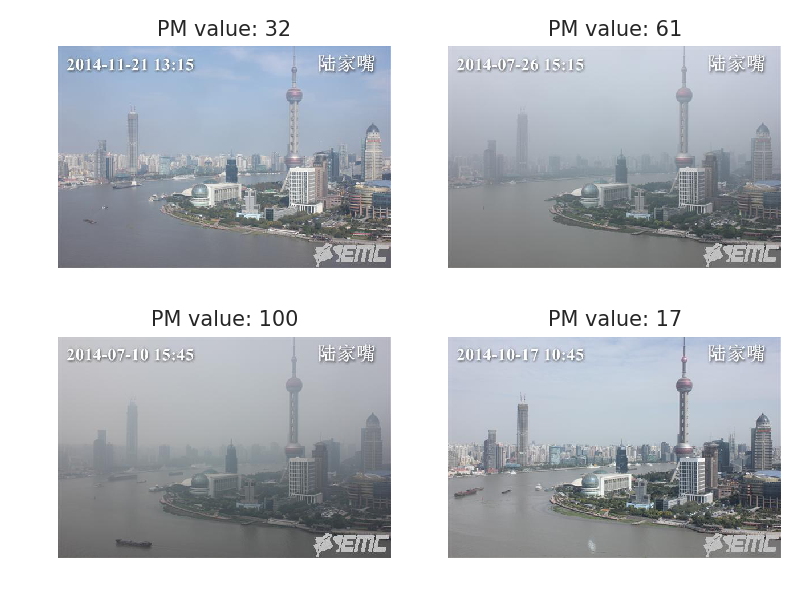

In [3]:
num_images=4 #number of images to display
np.random.seed(23)
#Selecting a sample of num_images 
sample_idxs=np.random.choice(len(df), size=num_images, replace=False)
samples=df.iloc[sample_idxs].values

#Creating subplots of samples from the dataset
fig=plt.figure()
for i in range(num_images):
    img_file=os.path.join(image_dir, samples[i, 0])
    pm_value=samples[i, 1]
    img = Image.open(img_file)
    ax=fig.add_subplot(math.ceil(num_images/2),2,i+1)
    ax.imshow(img)
    ax.set_title("PM value: {}".format(pm_value))
    ax.set_axis_off()
#automatically adjusts subplot params so that the subplot(s) fits in to the figure area.
fig.tight_layout()

In [5]:
print(df["pm_value"].describe())
#plt.figure()
#sns.boxplot(x=df["pm_value"])

count    1885.000000
mean       43.218037
std        28.155368
min         2.000000
25%        23.000000
50%        37.000000
75%        56.000000
max       209.000000
Name: pm_value, dtype: float64


<IPython.core.display.Javascript object>


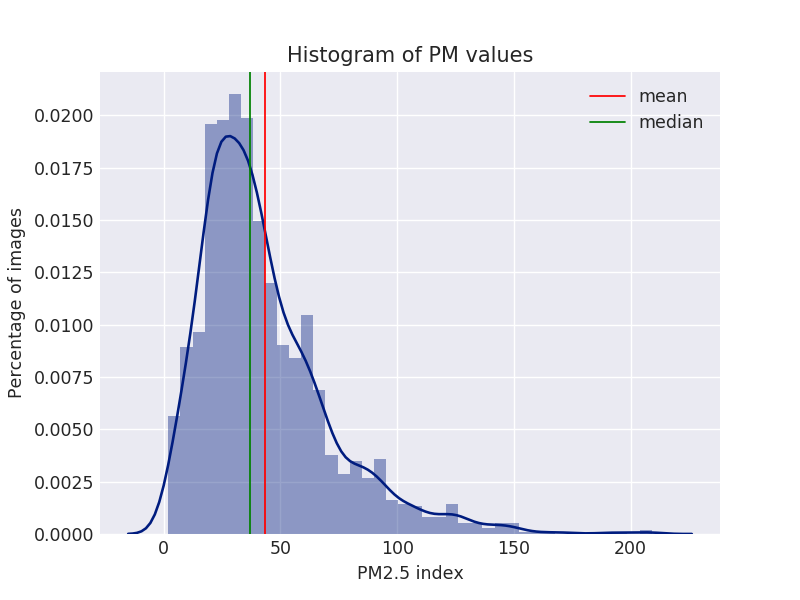

In [5]:
plt.figure()
sns.distplot(df['pm_value'], bins=40)
plt.axvline(df["pm_value"].mean(), color='r', linestyle='-', linewidth=1, label="mean")
plt.axvline(df["pm_value"].median(), color='g', linestyle='-', linewidth=1, label="median")
plt.legend()
plt.xlabel('PM2.5 index')
plt.ylabel('Percentage of images')
plt.title('Histogram of PM values')
plt.show()

### Dataset Preparation
- Dataset preparation for 5 fold CV
- Imageset is dividid into 5 folds each containing 20% of the data
- Each fold of data is used as test set once (Remaining 4 folds are used for training)

In [4]:
def create_dataset(preprocess_function, save_path): 
    height,width,depth = (224, 224, 3)
    output_dim=1
    folds=5
   
    X_data=[]
    Y_data=[] 
    Z_data=[]
    with open(image_list, "r") as file:
        #read csv from second line
        for item in file.readlines()[1:]:
            item=str(item).strip().split(",")
            #get the image file name
            image_file=os.path.join(image_dir, item[1])
            #load the image file 
            img = image.load_img(image_file, target_size=(height, width, depth))
            #convert image to numpy array
            x = image.img_to_array(img)
            # add one more dimension (batch)
            x = np.expand_dims(x, axis=0)
            #apply preprocessing to images
            x = preprocess_function(x)
            #append preprocessed image to the array
            X_data.append(x)
            Y_data.append(item[2])
            Z_data.append(item[1])

    X=np.array(X_data)
    Y=np.array(Y_data)
    Z=np.array(Z_data)
    number_of_images=len(X)
    
    #reshaping data
    X = X.reshape(number_of_images,height,width,depth)
    Y = Y.reshape(number_of_images, output_dim)
    Z = Z.reshape(number_of_images, output_dim)
    
    #shuffling the data
    X, Y, Z = shuffle(X, Y, Z, random_state=9)
    
    ##########################################################################
    #Preparing dataset for 5 fold CV
    ##########################################################################
    X_train=[]
    X_test=[]
    Y_train=[]
    Y_test=[]
    Z_train=[]
    Z_test=[]

    data_size=number_of_images
    test_size=int(data_size/folds)
    training_size=data_size-test_size

    for i in range(folds):
        lower_range=int(i*test_size)
        upper_range=int((i+1)*test_size-1)

        splitted_X=np.split(X, [lower_range, upper_range+1])
        splitted_Y=np.split(Y, [lower_range, upper_range+1])
        splitted_Z=np.split(Z, [lower_range, upper_range+1])

        train_X = np.append(splitted_X[0], splitted_X[2])
        test_X = splitted_X[1]

        train_Y = np.append(splitted_Y[0], splitted_Y[2])
        test_Y = splitted_Y[1]

        train_Z = np.append(splitted_Z[0], splitted_Z[2])
        test_Z = splitted_Z[1]


        X_train.append(train_X)
        X_test.append(test_X)

        Y_train.append(train_Y)
        Y_test.append(test_Y)

        Z_train.append(train_Z)
        Z_test.append(test_Z)


    Xtrain=np.array(X_train) 
    Xtest=np.array(X_test) 
    Ytrain=np.array(Y_train) 
    Ytest=np.array(Y_test)
    Ztrain=np.array(Z_train) 
    Ztest=np.array(Z_test)

    Xtrain=Xtrain.reshape(folds, training_size, width, height, depth) 
    Xtest=Xtest.reshape(folds, test_size, width, height, depth) 
    Ytrain=Ytrain.reshape(folds, training_size, output_dim) 
    Ytest=Ytest.reshape(folds, test_size, output_dim)
    Ztrain=Ztrain.reshape(folds, training_size, output_dim) 
    Ztest=Ztest.reshape(folds, test_size, output_dim)

    #saving the data
    np.savez(save_path, X_train=Xtrain, X_test=Xtest, y_train=Ytrain, y_test=Ytest, z_train=Ztrain, z_test=Ztest)
    print("Data successfully saved to file {}".format(save_path))
    

def load_data(path):
    data=np.load(path)
    X_train = data['X_train']
    X_test = data['X_test']
    Y_train = data['y_train']
    Y_test = data['y_test']
    Z_train = data['z_train']
    Z_test = data['z_test']
    return (X_train, X_test, Y_train, Y_test, Z_train, Z_test)

In [5]:
def vgg16():
    base_model = VGG16(weights='imagenet',input_shape=(224, 224, 3))
    #change the output to one neuron
    fc2 = base_model.get_layer('fc2').output
    fc3 = Dense(1, activation='linear', name='fc3')(fc2)
    #creating the modified CNN model
    model = Model(inputs=base_model.input, outputs=fc3)
    #freeze except the last layer of CNN
    for layer in base_model.layers:
        if layer.name=='fc3':
            continue
        else:
            layer.trainable=False
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


def resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable=False
    x= base_model.output
    output = Dense(1, activation='linear', name='output')(x)
    #creating the modified CNN model
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [6]:
def train_model(model, X_train, Y_train, test_fold, batch_size=64, max_epochs=100, name='vgg'):
    '''
    params:
    ------------------
    model: cnn model
    X_train, Y_train: training set
    test_fold: which fold to use as test set
    batch_size: batch size to use
    max_epochs: maximum number of epochs to train
    '''
    
    models_dir='models'
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)
    k=test_fold    
    filepath=os.path.join(models_dir, "{}_model{}.h5".format(name,k))
    #checkpoint the model if validation loss decreases
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='min')
    #reduce lr on pleateau
    reduce_on_plateau=ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=2, mode='min')
    #stop training if validation loss does not improve by 5 for 10 epoch continuously
    early_stopping=EarlyStopping(monitor='val_loss', min_delta=5.0, patience=10, verbose=2, mode='min')
    #tqdm_notebook=TQDMNotebookCallback(leave_inner=True, leave_outer=True)
    tqdm_notebook=TQDMNotebookCallback()
    callbacks_list = [checkpoint, reduce_on_plateau, early_stopping, tqdm_notebook]
    
    #split training data further into training and validation set
    xtrain, xval, ytrain, yval = train_test_split(X_train[k-1], Y_train[k-1], test_size=0.125)
    
    # augment training set by concatenating horizontally flipped images
    xtr = np.concatenate((xtrain, xtrain[:,:,::-1,:]), axis=0)
    ytr = np.concatenate((ytrain,ytrain), axis=0)
    
    train_history = model.fit(xtr, ytr, batch_size=batch_size, validation_data=(xval, yval),epochs=max_epochs, callbacks=callbacks_list, verbose=1)

    train_losses = np.sqrt(np.array(train_history.history['loss']))
    val_losses = np.sqrt(np.array(train_history.history['val_loss']))
    x_tick=[i+1 for i in range(len(train_losses))]
    plt.figure()
    plt.plot(x_tick,train_losses, label='training', marker='o', linestyle='solid')
    plt.plot(x_tick,val_losses, label='validation', marker='o', linestyle='solid')
    plt.legend(loc='upper right')
    plt.ylabel('Root Mean Square Error(RMSE)')
    plt.xlabel('# Epochs')
    plt.title('Loss')
    plt.grid()
    plt.show()    
    del model

In [7]:
def evaluate_model(model_name, X_test, Y_test, Z_test, test_fold, name='vgg'):
    eval_dir='eval'
    if not os.path.exists(eval_dir):
        os.makedirs(eval_dir)
    k=test_fold
    model = load_model(model_name)
    
    score = model.evaluate(X_test[k-1], Y_test[k-1], batch_size=64)
    rmse = np.sqrt(score)
    print('RMSE for Test data = {}'.format(rmse))
    
    #actual values
    x = np.array(Y_test[k-1])
    x = x.astype(np.float32)
    x = np.reshape(x, len(x))
    
    #predicted values
    y =np.array(model.predict(X_test[k-1]))
    y=np.reshape(y, len(y))
    y[y<0]=0
    
    z=Z_test[k-1]
    z=np.reshape(z, len(z))
    
    #saving the data
    save_path=os.path.join(eval_dir,'{}_eval_data{}.npz'.format(name,k))
    np.savez(save_path, x=x, y=y, z=z, rms=rmse)
    
    plt.figure()
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, y, '.', label="PM values")
    plt.plot(x, m*x + b, '-', label="line of best fit")
    plt.legend(loc='upper left')
    plt.ylabel('Prediction')
    plt.xlabel('Ground truth')
    plt.grid()
    plt.show()

In [7]:
#Create dataset(needs to be done only once)
#create_dataset(preprocess_function=vgg_preprocess_input, save_path='vgg_data.npz')
#create_dataset(preprocess_function=resnet_preprocess_input, save_path='resnet_data.npz')

### VGG16 as base model

In [11]:
# Load dataset
(X_train, X_test, Y_train, Y_test, Z_train, Z_test)=load_data('vgg_data.npz')

#img = Image.fromarray(X_train[0][0].astype(np.uint8))
#plt.imshow(img)

In [12]:
model=vgg16()

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### using first fold as test set

Train on 2638 samples, validate on 189 samples


A Jupyter Widget

A Jupyter Widget

Epoch 1/100
2638/2638 [==============================] - 17s 6ms/step - loss: 1235.1468 - val_loss: 819.4861


A Jupyter Widget

Epoch 2/100
2638/2638 [==============================] - 13s 5ms/step - loss: 783.6915 - val_loss: 694.6593


A Jupyter Widget

Epoch 3/100
2638/2638 [==============================] - 14s 5ms/step - loss: 700.4390 - val_loss: 622.6227


A Jupyter Widget

Epoch 4/100
2638/2638 [==============================] - 13s 5ms/step - loss: 631.0707 - val_loss: 566.3638


A Jupyter Widget

Epoch 5/100
2638/2638 [==============================] - 13s 5ms/step - loss: 571.0988 - val_loss: 520.9787


A Jupyter Widget

Epoch 6/100
2638/2638 [==============================] - 13s 5ms/step - loss: 520.7271 - val_loss: 481.5327


A Jupyter Widget

Epoch 7/100
2638/2638 [==============================] - 13s 5ms/step - loss: 478.4375 - val_loss: 461.5104


A Jupyter Widget

Epoch 8/100
2638/2638 [==============================] - 13s 5ms/step - loss: 446.2675 - val_loss: 427.4391


A Jupyter Widget

Epoch 9/100
2638/2638 [==============================] - 13s 5ms/step - loss: 416.9587 - val_loss: 406.6103


A Jupyter Widget

Epoch 10/100
2638/2638 [==============================] - 14s 5ms/step - loss: 393.2024 - val_loss: 387.0816


A Jupyter Widget

Epoch 11/100
2638/2638 [==============================] - 14s 5ms/step - loss: 373.4073 - val_loss: 373.2136


A Jupyter Widget

Epoch 12/100
2638/2638 [==============================] - 13s 5ms/step - loss: 356.9224 - val_loss: 361.6778


A Jupyter Widget

Epoch 13/100
2638/2638 [==============================] - 13s 5ms/step - loss: 341.7962 - val_loss: 350.6346


A Jupyter Widget

Epoch 14/100
2638/2638 [==============================] - 13s 5ms/step - loss: 330.6507 - val_loss: 340.5530


A Jupyter Widget

Epoch 15/100
2638/2638 [==============================] - 13s 5ms/step - loss: 320.8530 - val_loss: 333.7670


A Jupyter Widget

Epoch 16/100
2638/2638 [==============================] - 13s 5ms/step - loss: 310.7139 - val_loss: 327.0456


A Jupyter Widget

Epoch 17/100
2638/2638 [==============================] - 13s 5ms/step - loss: 302.8437 - val_loss: 317.9164


A Jupyter Widget

Epoch 18/100
2638/2638 [==============================] - 13s 5ms/step - loss: 296.0504 - val_loss: 310.7731


A Jupyter Widget

Epoch 19/100
2638/2638 [==============================] - 13s 5ms/step - loss: 290.8631 - val_loss: 306.1303


A Jupyter Widget

Epoch 20/100
2638/2638 [==============================] - 13s 5ms/step - loss: 283.3416 - val_loss: 301.0698


A Jupyter Widget

Epoch 21/100
2638/2638 [==============================] - 13s 5ms/step - loss: 278.3490 - val_loss: 297.8927


A Jupyter Widget

Epoch 22/100
2638/2638 [==============================] - 13s 5ms/step - loss: 273.1390 - val_loss: 290.3660


A Jupyter Widget

Epoch 23/100
2638/2638 [==============================] - 13s 5ms/step - loss: 269.7727 - val_loss: 288.9256


A Jupyter Widget

Epoch 24/100
2638/2638 [==============================] - 14s 5ms/step - loss: 265.5799 - val_loss: 283.3948


A Jupyter Widget

Epoch 25/100
2638/2638 [==============================] - 13s 5ms/step - loss: 261.8079 - val_loss: 278.9845


A Jupyter Widget

Epoch 26/100
2638/2638 [==============================] - 13s 5ms/step - loss: 257.1395 - val_loss: 275.2166


A Jupyter Widget

Epoch 27/100
2638/2638 [==============================] - 13s 5ms/step - loss: 253.1984 - val_loss: 271.4836


A Jupyter Widget

Epoch 28/100
2638/2638 [==============================] - 13s 5ms/step - loss: 250.2248 - val_loss: 271.0284


A Jupyter Widget

Epoch 29/100
2638/2638 [==============================] - 13s 5ms/step - loss: 246.6550 - val_loss: 265.1785


A Jupyter Widget

Epoch 30/100
2638/2638 [==============================] - 13s 5ms/step - loss: 244.2143 - val_loss: 262.6160


A Jupyter Widget

Epoch 31/100
2638/2638 [==============================] - 10s 4ms/step - loss: 240.9324 - val_loss: 266.6879


A Jupyter Widget

Epoch 32/100
2638/2638 [==============================] - 13s 5ms/step - loss: 239.9102 - val_loss: 256.4220


A Jupyter Widget

Epoch 33/100
2638/2638 [==============================] - 10s 4ms/step - loss: 236.1206 - val_loss: 256.7587


A Jupyter Widget

Epoch 34/100
2638/2638 [==============================] - 13s 5ms/step - loss: 233.3443 - val_loss: 252.7318


A Jupyter Widget

Epoch 35/100
2638/2638 [==============================] - 13s 5ms/step - loss: 230.5177 - val_loss: 250.0750


A Jupyter Widget

Epoch 36/100
2638/2638 [==============================] - 10s 4ms/step - loss: 228.1377 - val_loss: 255.9360


A Jupyter Widget

Epoch 37/100
2638/2638 [==============================] - 13s 5ms/step - loss: 227.8314 - val_loss: 245.3244


A Jupyter Widget

Epoch 38/100
2638/2638 [==============================] - 10s 4ms/step - loss: 226.1027 - val_loss: 251.2818


A Jupyter Widget

Epoch 39/100
2638/2638 [==============================] - 13s 5ms/step - loss: 222.0322 - val_loss: 242.8548


A Jupyter Widget

Epoch 40/100
2638/2638 [==============================] - 13s 5ms/step - loss: 219.7364 - val_loss: 239.3822


A Jupyter Widget

Epoch 41/100
2638/2638 [==============================] - 10s 4ms/step - loss: 217.0338 - val_loss: 240.7406


A Jupyter Widget

Epoch 42/100
2638/2638 [==============================] - 13s 5ms/step - loss: 215.3398 - val_loss: 235.6521


A Jupyter Widget

Epoch 43/100
2638/2638 [==============================] - 13s 5ms/step - loss: 213.9582 - val_loss: 233.0953


A Jupyter Widget

Epoch 44/100
2638/2638 [==============================] - 10s 4ms/step - loss: 211.6560 - val_loss: 233.6718


A Jupyter Widget

Epoch 45/100
2638/2638 [==============================] - 14s 5ms/step - loss: 210.3000 - val_loss: 230.6093


A Jupyter Widget

Epoch 46/100
2638/2638 [==============================] - 10s 4ms/step - loss: 208.3774 - val_loss: 233.1594


A Jupyter Widget

Epoch 47/100
2638/2638 [==============================] - 13s 5ms/step - loss: 206.5761 - val_loss: 227.4330


A Jupyter Widget

Epoch 48/100
2638/2638 [==============================] - 13s 5ms/step - loss: 206.2017 - val_loss: 225.9077


A Jupyter Widget

Epoch 49/100
2638/2638 [==============================] - 13s 5ms/step - loss: 202.8996 - val_loss: 224.9574


A Jupyter Widget

Epoch 50/100
2638/2638 [==============================] - 13s 5ms/step - loss: 202.5832 - val_loss: 223.5528


A Jupyter Widget

Epoch 51/100
2638/2638 [==============================] - 13s 5ms/step - loss: 200.6865 - val_loss: 222.0922


A Jupyter Widget

Epoch 52/100
2638/2638 [==============================] - 13s 5ms/step - loss: 198.3348 - val_loss: 220.9325


A Jupyter Widget

Epoch 53/100
2638/2638 [==============================] - 10s 4ms/step - loss: 196.9628 - val_loss: 225.0434


A Jupyter Widget

Epoch 54/100
2638/2638 [==============================] - 10s 4ms/step - loss: 197.9662 - val_loss: 244.8921


A Jupyter Widget

Epoch 55/100
2638/2638 [==============================] - 13s 5ms/step - loss: 196.8725 - val_loss: 220.2093


A Jupyter Widget

Epoch 56/100
2638/2638 [==============================] - 13s 5ms/step - loss: 192.7291 - val_loss: 218.1379


A Jupyter Widget

Epoch 57/100
2638/2638 [==============================] - 10s 4ms/step - loss: 191.5719 - val_loss: 220.8434


A Jupyter Widget

Epoch 58/100
2638/2638 [==============================] - 13s 5ms/step - loss: 190.1755 - val_loss: 216.1895


A Jupyter Widget

Epoch 59/100
2638/2638 [==============================] - 10s 4ms/step - loss: 189.7298 - val_loss: 221.4094


A Jupyter Widget

Epoch 60/100
2638/2638 [==============================] - 10s 4ms/step - loss: 189.3434 - val_loss: 218.2603


A Jupyter Widget

Epoch 61/100
2638/2638 [==============================] - 13s 5ms/step - loss: 186.5487 - val_loss: 211.6795


A Jupyter Widget

Epoch 62/100
2638/2638 [==============================] - 10s 4ms/step - loss: 186.4425 - val_loss: 224.9691


A Jupyter Widget

Epoch 63/100
2638/2638 [==============================] - 13s 5ms/step - loss: 186.2747 - val_loss: 209.5080


A Jupyter Widget

Epoch 64/100
2638/2638 [==============================] - 10s 4ms/step - loss: 184.0644 - val_loss: 211.1889


A Jupyter Widget

Epoch 65/100
2638/2638 [==============================] - 10s 4ms/step - loss: 182.4705 - val_loss: 209.9755


A Jupyter Widget

Epoch 66/100
2638/2638 [==============================] - 13s 5ms/step - loss: 180.4408 - val_loss: 206.2289


A Jupyter Widget

Epoch 67/100
2638/2638 [==============================] - 13s 5ms/step - loss: 180.8279 - val_loss: 205.1372


A Jupyter Widget

Epoch 68/100
2638/2638 [==============================] - 10s 4ms/step - loss: 178.4936 - val_loss: 206.1712


A Jupyter Widget

Epoch 69/100
2638/2638 [==============================] - 13s 5ms/step - loss: 177.4727 - val_loss: 203.7414


A Jupyter Widget

Epoch 70/100
2638/2638 [==============================] - 13s 5ms/step - loss: 177.4331 - val_loss: 203.5357


A Jupyter Widget

Epoch 71/100
2638/2638 [==============================] - 10s 4ms/step - loss: 175.3760 - val_loss: 205.7303


A Jupyter Widget

Epoch 72/100
2638/2638 [==============================] - 10s 4ms/step - loss: 175.9561 - val_loss: 210.1101


A Jupyter Widget

Epoch 73/100
2638/2638 [==============================] - 10s 4ms/step - loss: 175.3933 - val_loss: 206.9556


A Jupyter Widget

Epoch 74/100
2638/2638 [==============================] - 13s 5ms/step - loss: 175.4397 - val_loss: 199.1092


A Jupyter Widget

Epoch 75/100
2638/2638 [==============================] - 10s 4ms/step - loss: 171.5142 - val_loss: 201.9341


A Jupyter Widget

Epoch 76/100
2638/2638 [==============================] - 10s 4ms/step - loss: 172.3794 - val_loss: 200.6971


A Jupyter Widget

Epoch 77/100
2638/2638 [==============================] - 13s 5ms/step - loss: 170.4187 - val_loss: 196.9465


A Jupyter Widget

Epoch 78/100
2638/2638 [==============================] - 10s 4ms/step - loss: 169.3891 - val_loss: 210.9313


A Jupyter Widget

Epoch 79/100
2638/2638 [==============================] - 10s 4ms/step - loss: 169.7656 - val_loss: 200.7751


A Jupyter Widget

Epoch 80/100
2638/2638 [==============================] - 10s 4ms/step - loss: 169.5334 - val_loss: 202.9438


A Jupyter Widget

Epoch 81/100
2638/2638 [==============================] - 13s 5ms/step - loss: 167.2022 - val_loss: 194.1162


A Jupyter Widget

Epoch 82/100
2638/2638 [==============================] - 10s 4ms/step - loss: 167.4779 - val_loss: 195.8852


A Jupyter Widget

Epoch 83/100
2638/2638 [==============================] - 13s 5ms/step - loss: 164.9096 - val_loss: 192.7706


A Jupyter Widget

Epoch 84/100
2638/2638 [==============================] - 13s 5ms/step - loss: 164.6869 - val_loss: 192.4425


A Jupyter Widget

Epoch 85/100
2638/2638 [==============================] - 10s 4ms/step - loss: 163.6539 - val_loss: 196.0655


A Jupyter Widget

Epoch 86/100
2638/2638 [==============================] - 10s 4ms/step - loss: 162.7307 - val_loss: 193.4122


A Jupyter Widget

Epoch 87/100
2638/2638 [==============================] - 10s 4ms/step - loss: 161.2380 - val_loss: 197.3373


A Jupyter Widget

Epoch 88/100
2638/2638 [==============================] - 13s 5ms/step - loss: 160.5778 - val_loss: 189.5626


A Jupyter Widget

Epoch 89/100
2638/2638 [==============================] - 13s 5ms/step - loss: 161.8997 - val_loss: 189.0504


A Jupyter Widget

Epoch 90/100
2638/2638 [==============================] - 10s 4ms/step - loss: 159.6419 - val_loss: 195.0135


A Jupyter Widget

Epoch 91/100
2638/2638 [==============================] - 13s 5ms/step - loss: 159.2757 - val_loss: 187.9089


A Jupyter Widget

Epoch 92/100
2638/2638 [==============================] - 13s 5ms/step - loss: 160.0306 - val_loss: 187.5851


A Jupyter Widget

Epoch 93/100
2638/2638 [==============================] - 13s 5ms/step - loss: 158.3840 - val_loss: 187.2035


A Jupyter Widget

Epoch 94/100
2638/2638 [==============================] - 10s 4ms/step - loss: 156.2385 - val_loss: 189.0769


A Jupyter Widget

Epoch 95/100
2638/2638 [==============================] - 10s 4ms/step - loss: 157.2922 - val_loss: 188.7585


A Jupyter Widget

Epoch 96/100
2638/2638 [==============================] - 13s 5ms/step - loss: 156.2564 - val_loss: 186.8527


A Jupyter Widget

Epoch 97/100
2638/2638 [==============================] - 13s 5ms/step - loss: 154.9762 - val_loss: 185.5848


A Jupyter Widget

Epoch 98/100
2638/2638 [==============================] - 13s 5ms/step - loss: 153.9167 - val_loss: 184.6678


A Jupyter Widget

Epoch 99/100
2638/2638 [==============================] - 10s 4ms/step - loss: 153.1876 - val_loss: 187.9533


A Jupyter Widget

Epoch 100/100
2638/2638 [==============================] - 13s 5ms/step - loss: 153.9137 - val_loss: 184.3548



<IPython.core.display.Javascript object>


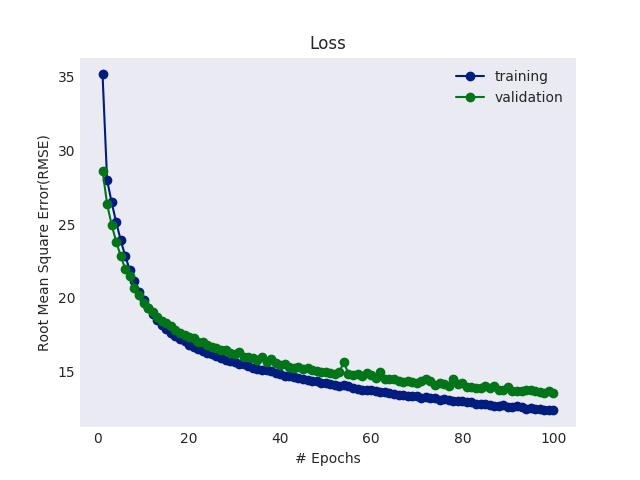

In [18]:
train_model(model, X_train, Y_train, test_fold=1, batch_size=64, max_epochs=100,name='vgg')

377/377 [==============================] - 2s 6ms/step
RMSE for Test data = 12.881946973081831


<IPython.core.display.Javascript object>


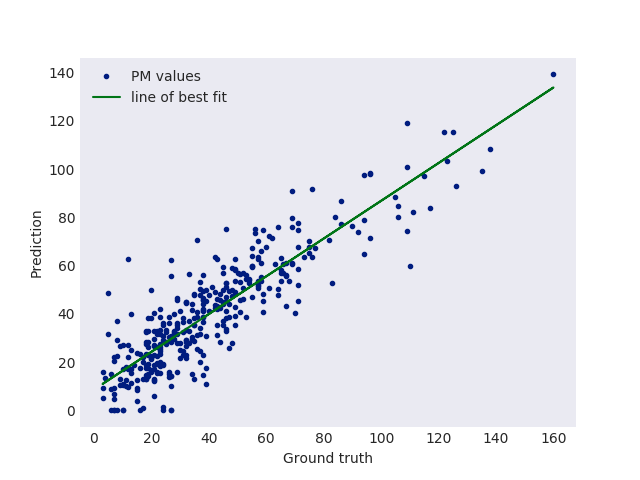

In [22]:
model_path="models/vgg_model1.h5"
evaluate_model(model_path, X_test, Y_test, Z_test, test_fold=1)

## using second fold as test set

Train on 2638 samples, validate on 189 samples


A Jupyter Widget

A Jupyter Widget

Epoch 1/100
2638/2638 [==============================] - 14s 5ms/step - loss: 1143.6484 - val_loss: 726.1959


A Jupyter Widget

Epoch 2/100
2638/2638 [==============================] - 14s 5ms/step - loss: 721.3583 - val_loss: 615.9150


A Jupyter Widget

Epoch 3/100
2638/2638 [==============================] - 13s 5ms/step - loss: 646.7483 - val_loss: 554.2636


A Jupyter Widget

Epoch 4/100
2638/2638 [==============================] - 13s 5ms/step - loss: 581.5530 - val_loss: 499.3264


A Jupyter Widget

Epoch 5/100
2638/2638 [==============================] - 13s 5ms/step - loss: 524.2542 - val_loss: 445.6603


A Jupyter Widget

Epoch 6/100
2638/2638 [==============================] - 13s 5ms/step - loss: 477.4200 - val_loss: 407.2192


A Jupyter Widget

Epoch 7/100
2638/2638 [==============================] - 13s 5ms/step - loss: 439.7602 - val_loss: 376.5965


A Jupyter Widget

Epoch 8/100
2638/2638 [==============================] - 14s 5ms/step - loss: 410.5440 - val_loss: 354.1150


A Jupyter Widget

Epoch 9/100
2638/2638 [==============================] - 13s 5ms/step - loss: 384.9921 - val_loss: 332.0530


A Jupyter Widget

Epoch 10/100
2638/2638 [==============================] - 13s 5ms/step - loss: 363.3951 - val_loss: 317.0666


A Jupyter Widget

Epoch 11/100
2638/2638 [==============================] - 13s 5ms/step - loss: 347.6486 - val_loss: 302.2596


A Jupyter Widget

Epoch 12/100
2638/2638 [==============================] - 13s 5ms/step - loss: 332.7236 - val_loss: 292.2529


A Jupyter Widget

Epoch 13/100
2638/2638 [==============================] - 13s 5ms/step - loss: 320.5372 - val_loss: 282.3176


A Jupyter Widget

Epoch 14/100
2638/2638 [==============================] - 13s 5ms/step - loss: 310.0912 - val_loss: 274.5551


A Jupyter Widget

Epoch 15/100
2638/2638 [==============================] - 13s 5ms/step - loss: 300.6946 - val_loss: 267.2439


A Jupyter Widget

Epoch 16/100
2638/2638 [==============================] - 13s 5ms/step - loss: 291.6597 - val_loss: 260.7368


A Jupyter Widget

Epoch 17/100
2638/2638 [==============================] - 13s 5ms/step - loss: 285.2104 - val_loss: 255.2988


A Jupyter Widget

Epoch 18/100
2638/2638 [==============================] - 13s 5ms/step - loss: 278.4506 - val_loss: 250.8934


A Jupyter Widget

Epoch 19/100
2638/2638 [==============================] - 13s 5ms/step - loss: 273.2119 - val_loss: 246.5962


A Jupyter Widget

Epoch 20/100
2638/2638 [==============================] - 13s 5ms/step - loss: 267.0134 - val_loss: 244.0244


A Jupyter Widget

Epoch 21/100
2638/2638 [==============================] - 13s 5ms/step - loss: 262.1448 - val_loss: 239.3245


A Jupyter Widget

Epoch 22/100
2638/2638 [==============================] - 11s 4ms/step - loss: 257.4593 - val_loss: 240.0876


A Jupyter Widget

Epoch 23/100
2638/2638 [==============================] - 13s 5ms/step - loss: 253.7545 - val_loss: 232.7934


A Jupyter Widget

Epoch 24/100
2638/2638 [==============================] - 13s 5ms/step - loss: 250.3848 - val_loss: 229.2560


A Jupyter Widget

Epoch 25/100
2638/2638 [==============================] - 13s 5ms/step - loss: 246.2386 - val_loss: 228.8440


A Jupyter Widget

Epoch 26/100
2638/2638 [==============================] - 13s 5ms/step - loss: 242.4653 - val_loss: 223.7650


A Jupyter Widget

Epoch 27/100
2638/2638 [==============================] - 11s 4ms/step - loss: 238.1717 - val_loss: 227.1586


A Jupyter Widget

Epoch 28/100
2638/2638 [==============================] - 13s 5ms/step - loss: 236.1506 - val_loss: 218.4137


A Jupyter Widget

Epoch 29/100
2638/2638 [==============================] - 13s 5ms/step - loss: 232.4687 - val_loss: 216.1187


A Jupyter Widget

Epoch 30/100
2638/2638 [==============================] - 13s 5ms/step - loss: 229.0825 - val_loss: 213.3826


A Jupyter Widget

Epoch 31/100
2638/2638 [==============================] - 11s 4ms/step - loss: 227.0677 - val_loss: 213.9542


A Jupyter Widget

Epoch 32/100
2638/2638 [==============================] - 11s 4ms/step - loss: 224.6704 - val_loss: 213.9778


A Jupyter Widget

Epoch 33/100
2638/2638 [==============================] - 13s 5ms/step - loss: 221.7502 - val_loss: 211.7062


A Jupyter Widget

Epoch 34/100
2638/2638 [==============================] - 13s 5ms/step - loss: 220.1166 - val_loss: 204.7426


A Jupyter Widget

Epoch 35/100
2638/2638 [==============================] - 13s 5ms/step - loss: 218.2367 - val_loss: 203.0406


A Jupyter Widget

Epoch 36/100
2638/2638 [==============================] - 13s 5ms/step - loss: 214.5310 - val_loss: 202.1061


A Jupyter Widget

Epoch 37/100
2638/2638 [==============================] - 11s 4ms/step - loss: 212.7264 - val_loss: 202.6363


A Jupyter Widget

Epoch 38/100
2638/2638 [==============================] - 13s 5ms/step - loss: 211.1278 - val_loss: 200.0205


A Jupyter Widget

Epoch 39/100
2638/2638 [==============================] - 13s 5ms/step - loss: 207.9793 - val_loss: 199.1911


A Jupyter Widget

Epoch 40/100
2638/2638 [==============================] - 13s 5ms/step - loss: 206.6843 - val_loss: 197.2645


A Jupyter Widget

Epoch 41/100
2638/2638 [==============================] - 13s 5ms/step - loss: 204.7503 - val_loss: 197.2159


A Jupyter Widget

Epoch 42/100
2638/2638 [==============================] - 14s 5ms/step - loss: 203.0848 - val_loss: 195.5732


A Jupyter Widget

Epoch 43/100
2638/2638 [==============================] - 13s 5ms/step - loss: 201.9314 - val_loss: 189.4848


A Jupyter Widget

Epoch 44/100
2638/2638 [==============================] - 11s 4ms/step - loss: 199.2453 - val_loss: 194.9451


A Jupyter Widget

Epoch 45/100
2638/2638 [==============================] - 14s 5ms/step - loss: 198.1050 - val_loss: 186.4176


A Jupyter Widget

Epoch 46/100
2638/2638 [==============================] - 11s 4ms/step - loss: 197.8265 - val_loss: 199.6362


A Jupyter Widget

Epoch 47/100
2638/2638 [==============================] - 13s 5ms/step - loss: 195.0367 - val_loss: 184.5641


A Jupyter Widget

Epoch 48/100
2638/2638 [==============================] - 14s 5ms/step - loss: 193.2150 - val_loss: 182.6734


A Jupyter Widget

Epoch 49/100
2638/2638 [==============================] - 11s 4ms/step - loss: 191.2940 - val_loss: 183.8588


A Jupyter Widget

Epoch 50/100
2638/2638 [==============================] - 14s 5ms/step - loss: 190.7172 - val_loss: 179.5246


A Jupyter Widget

Epoch 51/100
2638/2638 [==============================] - 13s 5ms/step - loss: 190.4828 - val_loss: 179.0171


A Jupyter Widget

Epoch 52/100
2638/2638 [==============================] - 13s 5ms/step - loss: 187.6108 - val_loss: 177.4569


A Jupyter Widget

Epoch 53/100
2638/2638 [==============================] - 14s 5ms/step - loss: 187.0905 - val_loss: 177.1142


A Jupyter Widget

Epoch 54/100
2638/2638 [==============================] - 13s 5ms/step - loss: 184.2786 - val_loss: 174.3222


A Jupyter Widget

Epoch 55/100
2638/2638 [==============================] - 11s 4ms/step - loss: 184.7572 - val_loss: 174.4364


A Jupyter Widget

Epoch 56/100
2638/2638 [==============================] - 13s 5ms/step - loss: 182.9715 - val_loss: 173.4887


A Jupyter Widget

Epoch 57/100
2638/2638 [==============================] - 13s 5ms/step - loss: 181.7520 - val_loss: 171.7625


A Jupyter Widget

Epoch 58/100
2638/2638 [==============================] - 10s 4ms/step - loss: 180.3957 - val_loss: 174.5126


A Jupyter Widget

Epoch 59/100
2638/2638 [==============================] - 13s 5ms/step - loss: 179.0354 - val_loss: 171.6453


A Jupyter Widget

Epoch 60/100
2638/2638 [==============================] - 14s 5ms/step - loss: 179.1057 - val_loss: 168.7519


A Jupyter Widget

Epoch 61/100
2638/2638 [==============================] - 11s 4ms/step - loss: 176.6716 - val_loss: 171.2963


A Jupyter Widget

Epoch 62/100
2638/2638 [==============================] - 11s 4ms/step - loss: 175.0032 - val_loss: 171.0049


A Jupyter Widget

Epoch 63/100
2638/2638 [==============================] - 14s 5ms/step - loss: 174.6587 - val_loss: 167.4755


A Jupyter Widget

Epoch 64/100
2638/2638 [==============================] - 13s 5ms/step - loss: 174.4615 - val_loss: 164.9616


A Jupyter Widget

Epoch 65/100
2638/2638 [==============================] - 11s 4ms/step - loss: 173.0442 - val_loss: 165.8319


A Jupyter Widget

Epoch 66/100
2638/2638 [==============================] - 11s 4ms/step - loss: 171.9322 - val_loss: 168.4020


A Jupyter Widget

Epoch 67/100
2638/2638 [==============================] - 13s 5ms/step - loss: 170.3056 - val_loss: 162.3588


A Jupyter Widget

Epoch 68/100
2638/2638 [==============================] - 13s 5ms/step - loss: 170.2261 - val_loss: 161.2719


A Jupyter Widget

Epoch 69/100
2638/2638 [==============================] - 13s 5ms/step - loss: 171.2595 - val_loss: 160.5063


A Jupyter Widget

Epoch 70/100
2638/2638 [==============================] - 13s 5ms/step - loss: 169.7178 - val_loss: 159.9991


A Jupyter Widget

Epoch 71/100
2638/2638 [==============================] - 10s 4ms/step - loss: 167.2046 - val_loss: 160.4976


A Jupyter Widget

Epoch 72/100
2638/2638 [==============================] - 13s 5ms/step - loss: 166.1986 - val_loss: 159.3631


A Jupyter Widget

Epoch 73/100
2638/2638 [==============================] - 11s 4ms/step - loss: 164.5798 - val_loss: 161.6231


A Jupyter Widget

Epoch 74/100
2638/2638 [==============================] - 11s 4ms/step - loss: 164.6477 - val_loss: 159.5227


A Jupyter Widget

Epoch 75/100
2638/2638 [==============================] - 11s 4ms/step - loss: 163.0240 - val_loss: 161.4479


A Jupyter Widget

Epoch 76/100
2638/2638 [==============================] - 13s 5ms/step - loss: 162.0009 - val_loss: 157.1961


A Jupyter Widget

Epoch 77/100
2638/2638 [==============================] - 11s 4ms/step - loss: 161.1328 - val_loss: 162.6469


A Jupyter Widget

Epoch 78/100
2638/2638 [==============================] - 11s 4ms/step - loss: 160.6916 - val_loss: 168.6685


A Jupyter Widget

Epoch 79/100
2638/2638 [==============================] - 11s 4ms/step - loss: 160.9380 - val_loss: 158.6867


A Jupyter Widget

Epoch 80/100
2638/2638 [==============================] - 11s 4ms/step - loss: 158.9928 - val_loss: 160.3856


A Jupyter Widget

Epoch 81/100
2638/2638 [==============================] - 13s 5ms/step - loss: 158.7994 - val_loss: 153.5698


A Jupyter Widget

Epoch 82/100
2638/2638 [==============================] - 13s 5ms/step - loss: 159.2166 - val_loss: 152.7019


A Jupyter Widget

Epoch 83/100
2638/2638 [==============================] - 13s 5ms/step - loss: 157.5258 - val_loss: 151.1156


A Jupyter Widget

Epoch 84/100
2638/2638 [==============================] - 11s 4ms/step - loss: 156.7014 - val_loss: 152.4625


A Jupyter Widget

Epoch 85/100
2638/2638 [==============================] - 13s 5ms/step - loss: 155.5345 - val_loss: 150.5043


A Jupyter Widget

Epoch 86/100
2638/2638 [==============================] - 13s 5ms/step - loss: 155.7528 - val_loss: 150.2219


A Jupyter Widget

Epoch 87/100
2638/2638 [==============================] - 13s 5ms/step - loss: 155.4329 - val_loss: 149.0213


A Jupyter Widget

Epoch 88/100
2638/2638 [==============================] - 11s 4ms/step - loss: 153.8829 - val_loss: 149.5934


A Jupyter Widget

Epoch 89/100
2638/2638 [==============================] - 11s 4ms/step - loss: 152.2769 - val_loss: 149.5319


A Jupyter Widget

Epoch 90/100
2638/2638 [==============================] - 11s 4ms/step - loss: 152.1204 - val_loss: 153.3543


A Jupyter Widget

Epoch 91/100
2638/2638 [==============================] - 13s 5ms/step - loss: 150.3789 - val_loss: 146.8678


A Jupyter Widget

Epoch 92/100
2638/2638 [==============================] - 13s 5ms/step - loss: 150.7341 - val_loss: 146.4779


A Jupyter Widget

Epoch 93/100
2638/2638 [==============================] - 13s 5ms/step - loss: 149.8486 - val_loss: 146.0654


A Jupyter Widget

Epoch 94/100
2638/2638 [==============================] - 11s 4ms/step - loss: 149.3509 - val_loss: 150.0798


A Jupyter Widget

Epoch 95/100
2638/2638 [==============================] - 11s 4ms/step - loss: 148.9216 - val_loss: 148.7555


A Jupyter Widget

Epoch 96/100
2638/2638 [==============================] - 13s 5ms/step - loss: 147.8532 - val_loss: 144.8251


A Jupyter Widget

Epoch 97/100
2638/2638 [==============================] - 11s 4ms/step - loss: 148.4903 - val_loss: 146.6085


A Jupyter Widget

Epoch 98/100
2638/2638 [==============================] - 11s 4ms/step - loss: 147.4103 - val_loss: 149.1150


A Jupyter Widget

Epoch 99/100
2638/2638 [==============================] - 11s 4ms/step - loss: 145.4734 - val_loss: 147.1944


A Jupyter Widget

Epoch 100/100
2638/2638 [==============================] - 11s 4ms/step - loss: 145.1655 - val_loss: 156.3340



<IPython.core.display.Javascript object>


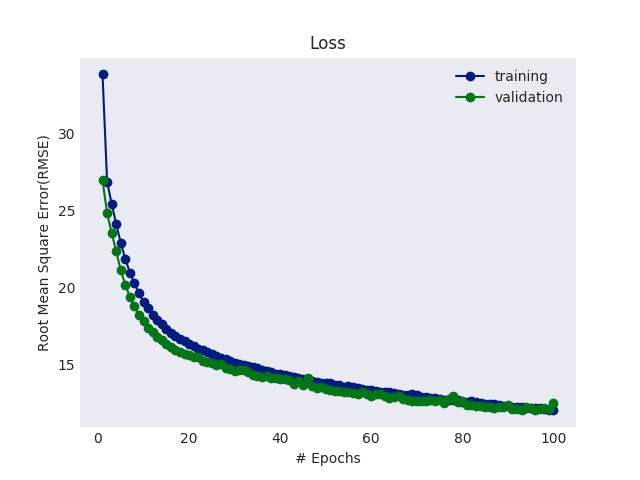

In [9]:
train_model(model, X_train, Y_train, test_fold=2, batch_size=64, max_epochs=100, name='vgg')

377/377 [==============================] - 2s 6ms/step
RMSE for Test data = 15.040848588617282


<IPython.core.display.Javascript object>


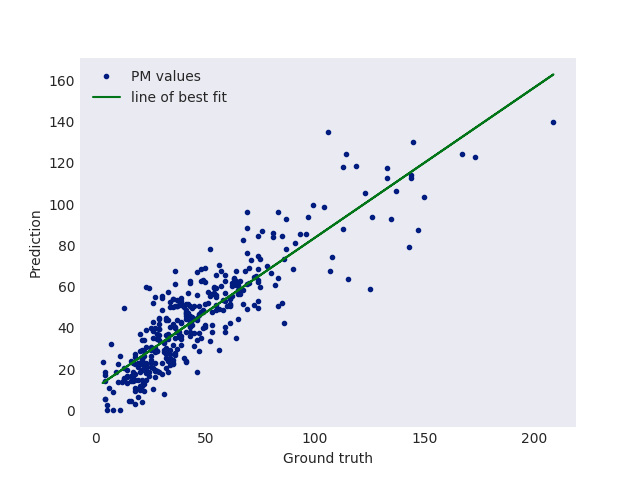

In [10]:
model_path="models/vgg_model2.h5"
evaluate_model(model_path, X_test, Y_test, Z_test, test_fold=2, name='vgg')

### using 3rd fold as test set

Train on 2638 samples, validate on 189 samples


A Jupyter Widget

A Jupyter Widget

Epoch 1/100
2638/2638 [==============================] - 14s 5ms/step - loss: 1179.8573 - val_loss: 804.5712


A Jupyter Widget

Epoch 2/100
2638/2638 [==============================] - 14s 5ms/step - loss: 760.6062 - val_loss: 693.9721


A Jupyter Widget

Epoch 3/100
2638/2638 [==============================] - 13s 5ms/step - loss: 680.1042 - val_loss: 628.6356


A Jupyter Widget

Epoch 4/100
2638/2638 [==============================] - 13s 5ms/step - loss: 611.2680 - val_loss: 576.2596


A Jupyter Widget

Epoch 5/100
2638/2638 [==============================] - 13s 5ms/step - loss: 554.9563 - val_loss: 526.9351


A Jupyter Widget

Epoch 6/100
2638/2638 [==============================] - 13s 5ms/step - loss: 506.2095 - val_loss: 487.2213


A Jupyter Widget

Epoch 7/100
2638/2638 [==============================] - 13s 5ms/step - loss: 465.0453 - val_loss: 455.3041


A Jupyter Widget

Epoch 8/100
2638/2638 [==============================] - 13s 5ms/step - loss: 433.6238 - val_loss: 426.0457


A Jupyter Widget

Epoch 9/100
2638/2638 [==============================] - 13s 5ms/step - loss: 407.2224 - val_loss: 406.8457


A Jupyter Widget

Epoch 10/100
2638/2638 [==============================] - 13s 5ms/step - loss: 385.9396 - val_loss: 390.0283


A Jupyter Widget

Epoch 11/100
2638/2638 [==============================] - 13s 5ms/step - loss: 368.4400 - val_loss: 374.9397


A Jupyter Widget

Epoch 12/100
2638/2638 [==============================] - 13s 5ms/step - loss: 352.0317 - val_loss: 360.2108


A Jupyter Widget

Epoch 13/100
2638/2638 [==============================] - 13s 5ms/step - loss: 337.7893 - val_loss: 351.3385


A Jupyter Widget

Epoch 14/100
2638/2638 [==============================] - 13s 5ms/step - loss: 326.8746 - val_loss: 338.7264


A Jupyter Widget

Epoch 15/100
2638/2638 [==============================] - 14s 5ms/step - loss: 316.7302 - val_loss: 331.6247


A Jupyter Widget

Epoch 16/100
2638/2638 [==============================] - 13s 5ms/step - loss: 308.1328 - val_loss: 320.6884


A Jupyter Widget

Epoch 17/100
2638/2638 [==============================] - 13s 5ms/step - loss: 300.5417 - val_loss: 317.2354


A Jupyter Widget

Epoch 18/100
2638/2638 [==============================] - 13s 5ms/step - loss: 295.4137 - val_loss: 311.7512


A Jupyter Widget

Epoch 19/100
2638/2638 [==============================] - 13s 5ms/step - loss: 287.3650 - val_loss: 302.2664


A Jupyter Widget

Epoch 20/100
2638/2638 [==============================] - 13s 5ms/step - loss: 283.1690 - val_loss: 295.9185


A Jupyter Widget

Epoch 21/100
2638/2638 [==============================] - 13s 5ms/step - loss: 277.1800 - val_loss: 291.5006


A Jupyter Widget

Epoch 22/100
2638/2638 [==============================] - 13s 5ms/step - loss: 272.7489 - val_loss: 284.3231


A Jupyter Widget

Epoch 23/100
2638/2638 [==============================] - 13s 5ms/step - loss: 268.3358 - val_loss: 282.1090


A Jupyter Widget

Epoch 24/100
2638/2638 [==============================] - 14s 5ms/step - loss: 264.9035 - val_loss: 278.4617


A Jupyter Widget

Epoch 25/100
2638/2638 [==============================] - 13s 5ms/step - loss: 260.5389 - val_loss: 269.9041


A Jupyter Widget

Epoch 26/100
2638/2638 [==============================] - 10s 4ms/step - loss: 257.1251 - val_loss: 272.9917


A Jupyter Widget

Epoch 27/100
2638/2638 [==============================] - 14s 5ms/step - loss: 252.9647 - val_loss: 266.4965


A Jupyter Widget

Epoch 28/100
2638/2638 [==============================] - 13s 5ms/step - loss: 249.6979 - val_loss: 260.8154


A Jupyter Widget

Epoch 29/100
2638/2638 [==============================] - 13s 5ms/step - loss: 246.6370 - val_loss: 255.4777


A Jupyter Widget

Epoch 30/100
2638/2638 [==============================] - 11s 4ms/step - loss: 243.6399 - val_loss: 255.5270


A Jupyter Widget

Epoch 31/100
2638/2638 [==============================] - 13s 5ms/step - loss: 241.3142 - val_loss: 249.3815


A Jupyter Widget

Epoch 32/100
2638/2638 [==============================] - 11s 4ms/step - loss: 238.4872 - val_loss: 254.9323


A Jupyter Widget

Epoch 33/100
2638/2638 [==============================] - 13s 5ms/step - loss: 235.8678 - val_loss: 248.5674


A Jupyter Widget

Epoch 34/100
2638/2638 [==============================] - 13s 5ms/step - loss: 232.4312 - val_loss: 246.2451


A Jupyter Widget

Epoch 35/100
2638/2638 [==============================] - 13s 5ms/step - loss: 232.4866 - val_loss: 240.1579


A Jupyter Widget

Epoch 36/100
2638/2638 [==============================] - 13s 5ms/step - loss: 227.9590 - val_loss: 239.5746


A Jupyter Widget

Epoch 37/100
2638/2638 [==============================] - 13s 5ms/step - loss: 225.3747 - val_loss: 234.2891


A Jupyter Widget

Epoch 38/100
2638/2638 [==============================] - 11s 4ms/step - loss: 223.3809 - val_loss: 242.2559


A Jupyter Widget

Epoch 39/100
2638/2638 [==============================] - 14s 5ms/step - loss: 220.9304 - val_loss: 226.6012


A Jupyter Widget

Epoch 40/100
2638/2638 [==============================] - 11s 4ms/step - loss: 219.0691 - val_loss: 230.7779


A Jupyter Widget

Epoch 41/100
2638/2638 [==============================] - 11s 4ms/step - loss: 216.1826 - val_loss: 228.1965


A Jupyter Widget

Epoch 42/100
2638/2638 [==============================] - 11s 4ms/step - loss: 214.3670 - val_loss: 235.3869


A Jupyter Widget

Epoch 43/100
2638/2638 [==============================] - 13s 5ms/step - loss: 212.8169 - val_loss: 225.0055


A Jupyter Widget

Epoch 44/100
2638/2638 [==============================] - 13s 5ms/step - loss: 210.9595 - val_loss: 221.3651


A Jupyter Widget

Epoch 45/100
2638/2638 [==============================] - 11s 4ms/step - loss: 209.3451 - val_loss: 224.2863


A Jupyter Widget

Epoch 46/100
2638/2638 [==============================] - 14s 5ms/step - loss: 208.4149 - val_loss: 218.4541


A Jupyter Widget

Epoch 47/100
2638/2638 [==============================] - 13s 5ms/step - loss: 206.4920 - val_loss: 217.7388


A Jupyter Widget

Epoch 48/100
2638/2638 [==============================] - 13s 5ms/step - loss: 204.7161 - val_loss: 216.8151


A Jupyter Widget

Epoch 49/100
2638/2638 [==============================] - 11s 4ms/step - loss: 205.0588 - val_loss: 217.8015


A Jupyter Widget

Epoch 50/100
2638/2638 [==============================] - 14s 5ms/step - loss: 200.9906 - val_loss: 211.9564


A Jupyter Widget

Epoch 51/100
2638/2638 [==============================] - 11s 4ms/step - loss: 199.8094 - val_loss: 213.2640


A Jupyter Widget

Epoch 52/100
2638/2638 [==============================] - 11s 4ms/step - loss: 199.0226 - val_loss: 222.7372


A Jupyter Widget

Epoch 53/100
2638/2638 [==============================] - 13s 5ms/step - loss: 197.4236 - val_loss: 210.6049


A Jupyter Widget

Epoch 54/100
2638/2638 [==============================] - 11s 4ms/step - loss: 196.0447 - val_loss: 210.6650


A Jupyter Widget

Epoch 55/100
2638/2638 [==============================] - 13s 5ms/step - loss: 193.3341 - val_loss: 209.9698


A Jupyter Widget

Epoch 56/100
2638/2638 [==============================] - 11s 4ms/step - loss: 193.1123 - val_loss: 210.0013


A Jupyter Widget

Epoch 57/100
2638/2638 [==============================] - 13s 5ms/step - loss: 192.3786 - val_loss: 205.1693


A Jupyter Widget

Epoch 58/100
2638/2638 [==============================] - 11s 4ms/step - loss: 190.7831 - val_loss: 206.1972


A Jupyter Widget

Epoch 59/100
2638/2638 [==============================] - 14s 5ms/step - loss: 188.1480 - val_loss: 202.0061


A Jupyter Widget

Epoch 60/100
2638/2638 [==============================] - 11s 4ms/step - loss: 188.3942 - val_loss: 204.3640


A Jupyter Widget

Epoch 61/100
2638/2638 [==============================] - 11s 4ms/step - loss: 186.3721 - val_loss: 204.0878


A Jupyter Widget

Epoch 62/100
2638/2638 [==============================] - 11s 4ms/step - loss: 184.9649 - val_loss: 202.7888


A Jupyter Widget

Epoch 63/100
2638/2638 [==============================] - 11s 4ms/step - loss: 184.1950 - val_loss: 205.4684


A Jupyter Widget

Epoch 64/100
2638/2638 [==============================] - 13s 5ms/step - loss: 182.6127 - val_loss: 197.8837


A Jupyter Widget

Epoch 65/100
2638/2638 [==============================] - 11s 4ms/step - loss: 181.9082 - val_loss: 200.2083


A Jupyter Widget

Epoch 66/100
2638/2638 [==============================] - 11s 4ms/step - loss: 180.5488 - val_loss: 199.1249


A Jupyter Widget

Epoch 67/100
2638/2638 [==============================] - 13s 5ms/step - loss: 179.7304 - val_loss: 197.5636


A Jupyter Widget

Epoch 68/100
2638/2638 [==============================] - 13s 5ms/step - loss: 178.4344 - val_loss: 196.0979


A Jupyter Widget

Epoch 69/100
2638/2638 [==============================] - 11s 4ms/step - loss: 178.5752 - val_loss: 199.4400


A Jupyter Widget

Epoch 70/100
2638/2638 [==============================] - 11s 4ms/step - loss: 176.2974 - val_loss: 203.8269


A Jupyter Widget

Epoch 71/100
2638/2638 [==============================] - 11s 4ms/step - loss: 176.8496 - val_loss: 200.0648


A Jupyter Widget

Epoch 72/100
2638/2638 [==============================] - 13s 5ms/step - loss: 175.0751 - val_loss: 192.1468


A Jupyter Widget

Epoch 73/100
2638/2638 [==============================] - 11s 4ms/step - loss: 173.6057 - val_loss: 193.6277


A Jupyter Widget

Epoch 74/100
2638/2638 [==============================] - 13s 5ms/step - loss: 172.4642 - val_loss: 191.2410


A Jupyter Widget

Epoch 75/100
2638/2638 [==============================] - 11s 4ms/step - loss: 171.7271 - val_loss: 206.8905


A Jupyter Widget

Epoch 76/100
2638/2638 [==============================] - 11s 4ms/step - loss: 172.9041 - val_loss: 199.5230


A Jupyter Widget

Epoch 77/100
2638/2638 [==============================] - 11s 4ms/step - loss: 170.5999 - val_loss: 209.4170


A Jupyter Widget

Epoch 78/100
2638/2638 [==============================] - 13s 5ms/step - loss: 172.6202 - val_loss: 189.1464


A Jupyter Widget

Epoch 79/100
2638/2638 [==============================] - 11s 4ms/step - loss: 168.3529 - val_loss: 190.5310


A Jupyter Widget

Epoch 80/100
2638/2638 [==============================] - 14s 5ms/step - loss: 167.7840 - val_loss: 186.7265


A Jupyter Widget

Epoch 81/100
2638/2638 [==============================] - 11s 4ms/step - loss: 168.7452 - val_loss: 187.6448


A Jupyter Widget

Epoch 82/100
2638/2638 [==============================] - 11s 4ms/step - loss: 167.5655 - val_loss: 188.4043


A Jupyter Widget

Epoch 83/100
2638/2638 [==============================] - 13s 5ms/step - loss: 164.8815 - val_loss: 185.6072


A Jupyter Widget

Epoch 84/100
2638/2638 [==============================] - 11s 4ms/step - loss: 164.7077 - val_loss: 185.7658


A Jupyter Widget

Epoch 85/100
2638/2638 [==============================] - 11s 4ms/step - loss: 163.5349 - val_loss: 190.5110


A Jupyter Widget

Epoch 86/100
2638/2638 [==============================] - 13s 5ms/step - loss: 163.7635 - val_loss: 185.4890


A Jupyter Widget

Epoch 87/100
2638/2638 [==============================] - 13s 5ms/step - loss: 163.8500 - val_loss: 181.9545


A Jupyter Widget

Epoch 88/100
2638/2638 [==============================] - 11s 4ms/step - loss: 163.3222 - val_loss: 187.2791


A Jupyter Widget

Epoch 89/100
2638/2638 [==============================] - 14s 5ms/step - loss: 161.9317 - val_loss: 181.5581


A Jupyter Widget

Epoch 90/100
2638/2638 [==============================] - 11s 4ms/step - loss: 160.9677 - val_loss: 187.7833


A Jupyter Widget

Epoch 91/100
2638/2638 [==============================] - 11s 4ms/step - loss: 159.0575 - val_loss: 185.8351


A Jupyter Widget

Epoch 92/100
2638/2638 [==============================] - 11s 4ms/step - loss: 158.9142 - val_loss: 183.3707


A Jupyter Widget

Epoch 93/100
2638/2638 [==============================] - 13s 5ms/step - loss: 157.7976 - val_loss: 180.7877


A Jupyter Widget

Epoch 94/100
2638/2638 [==============================] - 11s 4ms/step - loss: 157.3064 - val_loss: 180.9274


A Jupyter Widget

Epoch 95/100
2638/2638 [==============================] - 11s 4ms/step - loss: 157.2794 - val_loss: 184.3012


A Jupyter Widget

Epoch 96/100
2638/2638 [==============================] - 11s 4ms/step - loss: 155.8623 - val_loss: 183.3700


A Jupyter Widget

Epoch 97/100
2638/2638 [==============================] - 13s 5ms/step - loss: 155.1158 - val_loss: 179.0408


A Jupyter Widget

Epoch 98/100
2638/2638 [==============================] - 11s 4ms/step - loss: 155.1897 - val_loss: 180.5498


A Jupyter Widget

Epoch 99/100
2638/2638 [==============================] - 11s 4ms/step - loss: 154.6931 - val_loss: 185.5019
Epoch 00099: early stopping



<IPython.core.display.Javascript object>


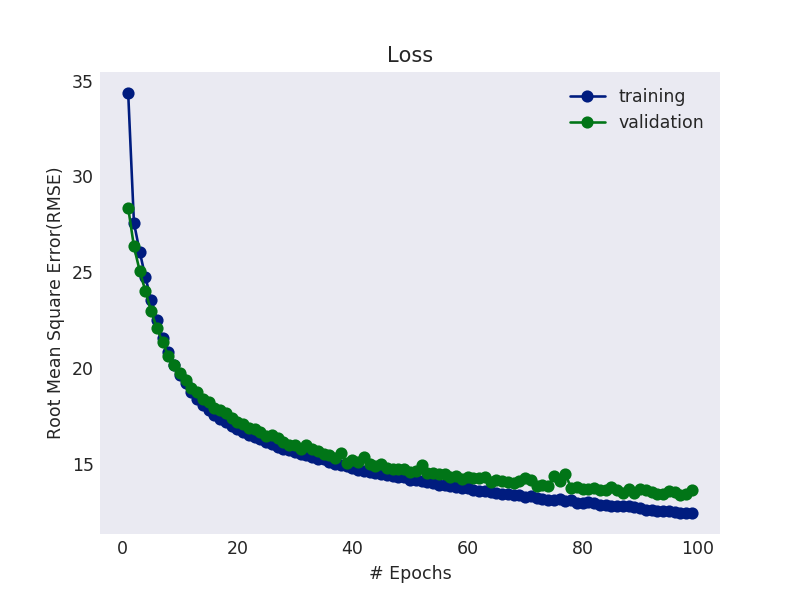

In [9]:
train_model(model, X_train, Y_train, test_fold=3, batch_size=64, max_epochs=100, name='vgg')

377/377 [==============================] - 2s 6ms/step
RMSE for Test data = 12.902278552657501


<IPython.core.display.Javascript object>


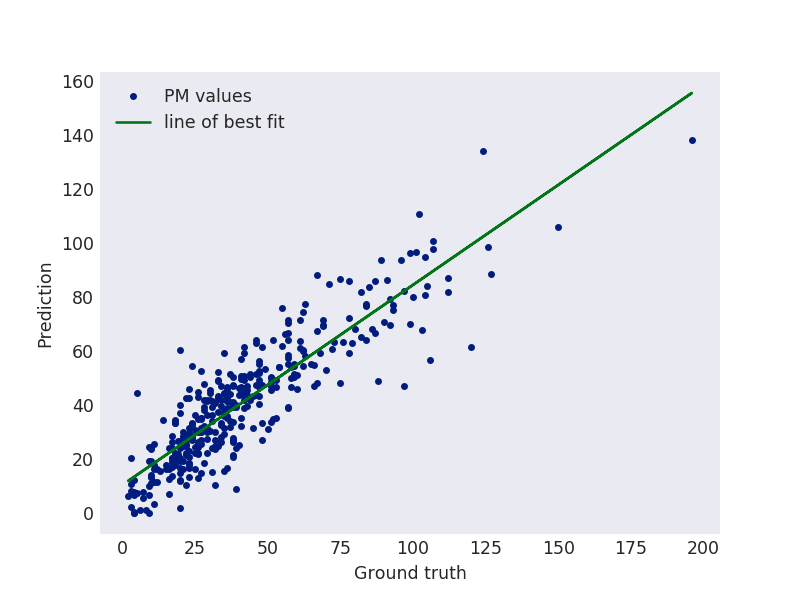

In [10]:
model_path="models/vgg_model3.h5"
evaluate_model(model_path, X_test, Y_test, Z_test, test_fold=3, name='vgg')

### 4th fold as test set

Train on 2638 samples, validate on 189 samples


A Jupyter Widget

A Jupyter Widget

Epoch 1/100
2638/2638 [==============================] - 14s 5ms/step - loss: 1232.9762 - val_loss: 851.6702


A Jupyter Widget

Epoch 2/100
2638/2638 [==============================] - 14s 5ms/step - loss: 770.0874 - val_loss: 747.6057


A Jupyter Widget

Epoch 3/100
2638/2638 [==============================] - 13s 5ms/step - loss: 683.7354 - val_loss: 676.8718


A Jupyter Widget

Epoch 4/100
2638/2638 [==============================] - 13s 5ms/step - loss: 610.1473 - val_loss: 625.3027


A Jupyter Widget

Epoch 5/100
2638/2638 [==============================] - 13s 5ms/step - loss: 549.8860 - val_loss: 578.3865


A Jupyter Widget

Epoch 6/100
2638/2638 [==============================] - 13s 5ms/step - loss: 500.2140 - val_loss: 544.0413


A Jupyter Widget

Epoch 7/100
2638/2638 [==============================] - 13s 5ms/step - loss: 458.2717 - val_loss: 518.5213


A Jupyter Widget

Epoch 8/100
2638/2638 [==============================] - 13s 5ms/step - loss: 425.9024 - val_loss: 491.6079


A Jupyter Widget

Epoch 9/100
2638/2638 [==============================] - 13s 5ms/step - loss: 399.7116 - val_loss: 477.7245


A Jupyter Widget

Epoch 10/100
2638/2638 [==============================] - 13s 5ms/step - loss: 379.5650 - val_loss: 454.7726


A Jupyter Widget

Epoch 11/100
2638/2638 [==============================] - 13s 5ms/step - loss: 359.1108 - val_loss: 439.3800


A Jupyter Widget

Epoch 12/100
2638/2638 [==============================] - 13s 5ms/step - loss: 343.1424 - val_loss: 424.2922


A Jupyter Widget

Epoch 13/100
2638/2638 [==============================] - 13s 5ms/step - loss: 330.1017 - val_loss: 414.6456


A Jupyter Widget

Epoch 14/100
2638/2638 [==============================] - 13s 5ms/step - loss: 320.1899 - val_loss: 401.1065


A Jupyter Widget

Epoch 15/100
2638/2638 [==============================] - 13s 5ms/step - loss: 307.7054 - val_loss: 391.7785


A Jupyter Widget

Epoch 16/100
2638/2638 [==============================] - 13s 5ms/step - loss: 300.9074 - val_loss: 388.2401


A Jupyter Widget

Epoch 17/100
2638/2638 [==============================] - 13s 5ms/step - loss: 292.0842 - val_loss: 377.7106


A Jupyter Widget

Epoch 18/100
2638/2638 [==============================] - 14s 5ms/step - loss: 286.5332 - val_loss: 368.1911


A Jupyter Widget

Epoch 19/100
2638/2638 [==============================] - 13s 5ms/step - loss: 278.0527 - val_loss: 363.4588


A Jupyter Widget

Epoch 20/100
2638/2638 [==============================] - 13s 5ms/step - loss: 272.6168 - val_loss: 354.2837


A Jupyter Widget

Epoch 21/100
2638/2638 [==============================] - 13s 5ms/step - loss: 267.8958 - val_loss: 349.9488


A Jupyter Widget

Epoch 22/100
2638/2638 [==============================] - 13s 5ms/step - loss: 262.8704 - val_loss: 344.3642


A Jupyter Widget

Epoch 23/100
2638/2638 [==============================] - 13s 5ms/step - loss: 258.9084 - val_loss: 343.6479


A Jupyter Widget

Epoch 24/100
2638/2638 [==============================] - 13s 5ms/step - loss: 254.1218 - val_loss: 335.7067


A Jupyter Widget

Epoch 25/100
2638/2638 [==============================] - 13s 5ms/step - loss: 251.7393 - val_loss: 333.7665


A Jupyter Widget

Epoch 26/100
2638/2638 [==============================] - 13s 5ms/step - loss: 248.8653 - val_loss: 324.9608


A Jupyter Widget

Epoch 27/100
2638/2638 [==============================] - 13s 5ms/step - loss: 244.3364 - val_loss: 324.0621


A Jupyter Widget

Epoch 28/100
2638/2638 [==============================] - 13s 5ms/step - loss: 241.4364 - val_loss: 320.3729


A Jupyter Widget

Epoch 29/100
2638/2638 [==============================] - 13s 5ms/step - loss: 240.6387 - val_loss: 313.6900


A Jupyter Widget

Epoch 30/100
2638/2638 [==============================] - 13s 5ms/step - loss: 236.9987 - val_loss: 311.3435


A Jupyter Widget

Epoch 31/100
2638/2638 [==============================] - 13s 5ms/step - loss: 232.7058 - val_loss: 302.4030


A Jupyter Widget

Epoch 32/100
2638/2638 [==============================] - 13s 5ms/step - loss: 231.2363 - val_loss: 301.4083


A Jupyter Widget

Epoch 33/100
2638/2638 [==============================] - 14s 5ms/step - loss: 228.0650 - val_loss: 297.7322


A Jupyter Widget

Epoch 34/100
2638/2638 [==============================] - 13s 5ms/step - loss: 226.2047 - val_loss: 295.3784


A Jupyter Widget

Epoch 35/100
2638/2638 [==============================] - 13s 5ms/step - loss: 222.3655 - val_loss: 290.5955


A Jupyter Widget

Epoch 36/100
2638/2638 [==============================] - 11s 4ms/step - loss: 220.4320 - val_loss: 290.7997


A Jupyter Widget

Epoch 37/100
2638/2638 [==============================] - 13s 5ms/step - loss: 218.7164 - val_loss: 284.1792


A Jupyter Widget

Epoch 38/100
2638/2638 [==============================] - 11s 4ms/step - loss: 217.6529 - val_loss: 285.9728


A Jupyter Widget

Epoch 39/100
2638/2638 [==============================] - 13s 5ms/step - loss: 214.7477 - val_loss: 283.4955


A Jupyter Widget

Epoch 40/100
2638/2638 [==============================] - 14s 5ms/step - loss: 212.9083 - val_loss: 280.3941


A Jupyter Widget

Epoch 41/100
2638/2638 [==============================] - 13s 5ms/step - loss: 210.2430 - val_loss: 276.1369


A Jupyter Widget

Epoch 42/100
2638/2638 [==============================] - 13s 5ms/step - loss: 208.3567 - val_loss: 274.9280


A Jupyter Widget

Epoch 43/100
2638/2638 [==============================] - 13s 5ms/step - loss: 206.6337 - val_loss: 270.0164


A Jupyter Widget

Epoch 44/100
2638/2638 [==============================] - 11s 4ms/step - loss: 205.9453 - val_loss: 272.1600


A Jupyter Widget

Epoch 45/100
2638/2638 [==============================] - 14s 5ms/step - loss: 203.6938 - val_loss: 267.1528


A Jupyter Widget

Epoch 46/100
2638/2638 [==============================] - 11s 4ms/step - loss: 201.6595 - val_loss: 267.1701


A Jupyter Widget

Epoch 47/100
2638/2638 [==============================] - 11s 4ms/step - loss: 201.1515 - val_loss: 269.8772


A Jupyter Widget

Epoch 48/100
2638/2638 [==============================] - 11s 4ms/step - loss: 199.8869 - val_loss: 275.6855


A Jupyter Widget

Epoch 49/100
2638/2638 [==============================] - 13s 5ms/step - loss: 198.6250 - val_loss: 259.1667


A Jupyter Widget

Epoch 50/100
2638/2638 [==============================] - 13s 5ms/step - loss: 197.3786 - val_loss: 256.8117


A Jupyter Widget

Epoch 51/100
2638/2638 [==============================] - 11s 4ms/step - loss: 195.9058 - val_loss: 257.5730


A Jupyter Widget

Epoch 52/100
2638/2638 [==============================] - 13s 5ms/step - loss: 195.3087 - val_loss: 253.7669


A Jupyter Widget

Epoch 53/100
2638/2638 [==============================] - 13s 5ms/step - loss: 192.3515 - val_loss: 249.9384


A Jupyter Widget

Epoch 54/100
2638/2638 [==============================] - 13s 5ms/step - loss: 190.7263 - val_loss: 247.8408


A Jupyter Widget

Epoch 55/100
2638/2638 [==============================] - 13s 5ms/step - loss: 190.6127 - val_loss: 247.0453


A Jupyter Widget

Epoch 56/100
2638/2638 [==============================] - 11s 4ms/step - loss: 187.5998 - val_loss: 253.2786


A Jupyter Widget

Epoch 57/100
2638/2638 [==============================] - 14s 5ms/step - loss: 189.5845 - val_loss: 242.9369


A Jupyter Widget

Epoch 58/100
2638/2638 [==============================] - 13s 5ms/step - loss: 185.8881 - val_loss: 242.1207


A Jupyter Widget

Epoch 59/100
2638/2638 [==============================] - 11s 4ms/step - loss: 184.8710 - val_loss: 243.9788


A Jupyter Widget

Epoch 60/100
2638/2638 [==============================] - 14s 5ms/step - loss: 183.1338 - val_loss: 240.4084


A Jupyter Widget

Epoch 61/100
2638/2638 [==============================] - 13s 5ms/step - loss: 182.3921 - val_loss: 240.0871


A Jupyter Widget

Epoch 62/100
2638/2638 [==============================] - 13s 5ms/step - loss: 183.6404 - val_loss: 236.2034


A Jupyter Widget

Epoch 63/100
2638/2638 [==============================] - 11s 4ms/step - loss: 179.9865 - val_loss: 239.9080


A Jupyter Widget

Epoch 64/100
2638/2638 [==============================] - 11s 4ms/step - loss: 179.0356 - val_loss: 236.5045


A Jupyter Widget

Epoch 65/100
2638/2638 [==============================] - 14s 5ms/step - loss: 178.0402 - val_loss: 232.6681


A Jupyter Widget

Epoch 66/100
2638/2638 [==============================] - 11s 4ms/step - loss: 178.8788 - val_loss: 234.7349


A Jupyter Widget

Epoch 67/100
2638/2638 [==============================] - 13s 5ms/step - loss: 176.8888 - val_loss: 229.5733


A Jupyter Widget

Epoch 68/100
2638/2638 [==============================] - 11s 4ms/step - loss: 175.8071 - val_loss: 230.9115


A Jupyter Widget

Epoch 69/100
2638/2638 [==============================] - 13s 5ms/step - loss: 174.8619 - val_loss: 228.8309


A Jupyter Widget

Epoch 70/100
2638/2638 [==============================] - 11s 4ms/step - loss: 173.0013 - val_loss: 239.1505


A Jupyter Widget

Epoch 71/100
2638/2638 [==============================] - 11s 4ms/step - loss: 173.2960 - val_loss: 228.9604


A Jupyter Widget

Epoch 72/100
2638/2638 [==============================] - 13s 5ms/step - loss: 171.2762 - val_loss: 226.5152


A Jupyter Widget

Epoch 73/100
2638/2638 [==============================] - 14s 5ms/step - loss: 170.9064 - val_loss: 221.7759


A Jupyter Widget

Epoch 74/100
2638/2638 [==============================] - 11s 4ms/step - loss: 171.1761 - val_loss: 225.1950


A Jupyter Widget

Epoch 75/100
2638/2638 [==============================] - 11s 4ms/step - loss: 168.7462 - val_loss: 222.7896


A Jupyter Widget

Epoch 76/100
2638/2638 [==============================] - 11s 4ms/step - loss: 167.7184 - val_loss: 221.8249


A Jupyter Widget

Epoch 77/100
2638/2638 [==============================] - 13s 5ms/step - loss: 168.8524 - val_loss: 219.6793


A Jupyter Widget

Epoch 78/100
2638/2638 [==============================] - 11s 4ms/step - loss: 167.9923 - val_loss: 220.7980


A Jupyter Widget

Epoch 79/100
2638/2638 [==============================] - 13s 5ms/step - loss: 166.3822 - val_loss: 218.2509


A Jupyter Widget

Epoch 80/100
2638/2638 [==============================] - 14s 5ms/step - loss: 164.0633 - val_loss: 217.2538


A Jupyter Widget

Epoch 81/100
2638/2638 [==============================] - 11s 4ms/step - loss: 163.7999 - val_loss: 223.0310


A Jupyter Widget

Epoch 82/100
2638/2638 [==============================] - 11s 4ms/step - loss: 162.4267 - val_loss: 222.2243


A Jupyter Widget

Epoch 83/100
2638/2638 [==============================] - 14s 5ms/step - loss: 163.3403 - val_loss: 212.2289


A Jupyter Widget

Epoch 84/100
2638/2638 [==============================] - 11s 4ms/step - loss: 162.0409 - val_loss: 217.7573


A Jupyter Widget

Epoch 85/100
2638/2638 [==============================] - 11s 4ms/step - loss: 162.4597 - val_loss: 212.9774


A Jupyter Widget

Epoch 86/100
2638/2638 [==============================] - 13s 5ms/step - loss: 160.2138 - val_loss: 210.8064


A Jupyter Widget

Epoch 87/100
2638/2638 [==============================] - 11s 4ms/step - loss: 159.7272 - val_loss: 211.3299


A Jupyter Widget

Epoch 88/100
2638/2638 [==============================] - 11s 4ms/step - loss: 159.6695 - val_loss: 212.9988


A Jupyter Widget

Epoch 89/100
2638/2638 [==============================] - 14s 5ms/step - loss: 161.5279 - val_loss: 207.8316


A Jupyter Widget

Epoch 90/100
2638/2638 [==============================] - 11s 4ms/step - loss: 157.5224 - val_loss: 213.8982


A Jupyter Widget

Epoch 91/100
2638/2638 [==============================] - 13s 5ms/step - loss: 156.9150 - val_loss: 206.2417


A Jupyter Widget

Epoch 92/100
2638/2638 [==============================] - 11s 4ms/step - loss: 156.5667 - val_loss: 207.3899


A Jupyter Widget

Epoch 93/100
2638/2638 [==============================] - 11s 4ms/step - loss: 155.4618 - val_loss: 207.0051


A Jupyter Widget

Epoch 94/100
2638/2638 [==============================] - 11s 4ms/step - loss: 155.5834 - val_loss: 208.1961


A Jupyter Widget

Epoch 95/100
2638/2638 [==============================] - 13s 5ms/step - loss: 154.0459 - val_loss: 203.2185


A Jupyter Widget

Epoch 96/100
2638/2638 [==============================] - 11s 4ms/step - loss: 154.2519 - val_loss: 206.1264


A Jupyter Widget

Epoch 97/100
2638/2638 [==============================] - 11s 4ms/step - loss: 152.4280 - val_loss: 206.9457


A Jupyter Widget

Epoch 98/100
2638/2638 [==============================] - 11s 4ms/step - loss: 152.6504 - val_loss: 211.1164


A Jupyter Widget

Epoch 99/100
2638/2638 [==============================] - 11s 4ms/step - loss: 152.1507 - val_loss: 207.1201


A Jupyter Widget

Epoch 100/100
2638/2638 [==============================] - 11s 4ms/step - loss: 151.0683 - val_loss: 205.4004



<IPython.core.display.Javascript object>


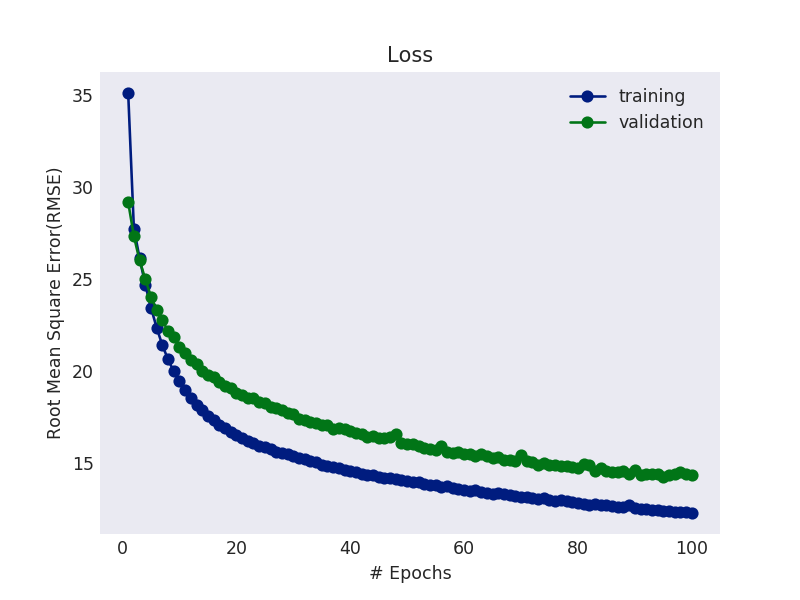

In [13]:
train_model(model, X_train, Y_train, test_fold=4, batch_size=64, max_epochs=100, name='vgg')

377/377 [==============================] - 2s 6ms/step
RMSE for Test data = 13.636475838760013


<IPython.core.display.Javascript object>


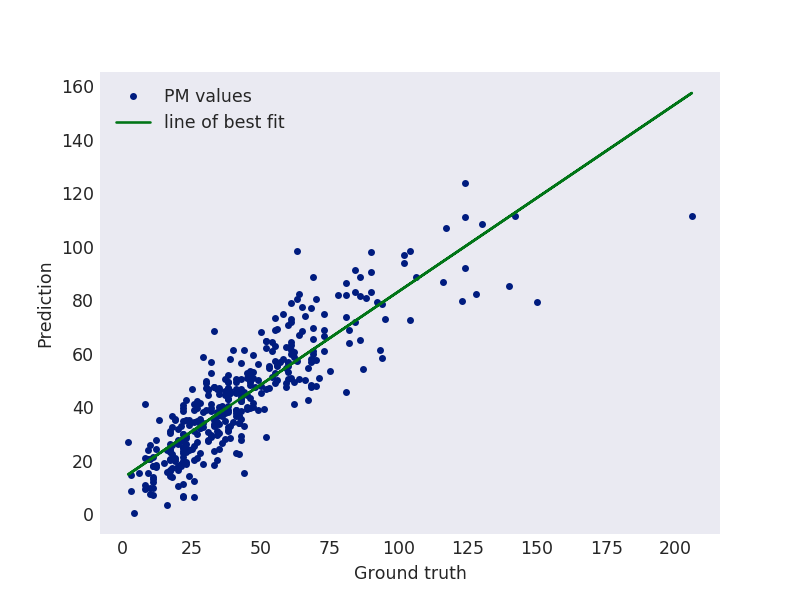

In [14]:
model_path="models/vgg_model4.h5"
evaluate_model(model_path, X_test, Y_test, Z_test, test_fold=4, name='vgg')

### 5th fold as test set

Train on 2638 samples, validate on 189 samples


A Jupyter Widget

A Jupyter Widget

Epoch 1/100
2638/2638 [==============================] - 14s 5ms/step - loss: 1196.7973 - val_loss: 732.3191


A Jupyter Widget

Epoch 2/100
2638/2638 [==============================] - 14s 5ms/step - loss: 786.1968 - val_loss: 621.3712


A Jupyter Widget

Epoch 3/100
2638/2638 [==============================] - 14s 5ms/step - loss: 697.1445 - val_loss: 538.7635


A Jupyter Widget

Epoch 4/100
2638/2638 [==============================] - 14s 5ms/step - loss: 623.7462 - val_loss: 479.4494


A Jupyter Widget

Epoch 5/100
2638/2638 [==============================] - 13s 5ms/step - loss: 562.8847 - val_loss: 433.2277


A Jupyter Widget

Epoch 6/100
2638/2638 [==============================] - 13s 5ms/step - loss: 511.0009 - val_loss: 400.9014


A Jupyter Widget

Epoch 7/100
2638/2638 [==============================] - 14s 5ms/step - loss: 470.2803 - val_loss: 373.2050


A Jupyter Widget

Epoch 8/100
2638/2638 [==============================] - 13s 5ms/step - loss: 435.7961 - val_loss: 342.3295


A Jupyter Widget

Epoch 9/100
2638/2638 [==============================] - 13s 5ms/step - loss: 408.2426 - val_loss: 323.7275


A Jupyter Widget

Epoch 10/100
2638/2638 [==============================] - 13s 5ms/step - loss: 384.9063 - val_loss: 309.3220


A Jupyter Widget

Epoch 11/100
2638/2638 [==============================] - 14s 5ms/step - loss: 365.4733 - val_loss: 295.6056


A Jupyter Widget

Epoch 12/100
2638/2638 [==============================] - 14s 5ms/step - loss: 350.4357 - val_loss: 287.8746


A Jupyter Widget

Epoch 13/100
2638/2638 [==============================] - 14s 5ms/step - loss: 336.3022 - val_loss: 284.7959


A Jupyter Widget

Epoch 14/100
2638/2638 [==============================] - 14s 5ms/step - loss: 325.1115 - val_loss: 272.7321


A Jupyter Widget

Epoch 15/100
2638/2638 [==============================] - 13s 5ms/step - loss: 315.2246 - val_loss: 265.9474


A Jupyter Widget

Epoch 16/100
2638/2638 [==============================] - 13s 5ms/step - loss: 306.7393 - val_loss: 260.2433


A Jupyter Widget

Epoch 17/100
2638/2638 [==============================] - 13s 5ms/step - loss: 299.1606 - val_loss: 254.7580


A Jupyter Widget

Epoch 18/100
2638/2638 [==============================] - 13s 5ms/step - loss: 293.0633 - val_loss: 250.4872


A Jupyter Widget

Epoch 19/100
2638/2638 [==============================] - 14s 5ms/step - loss: 286.0108 - val_loss: 247.3206


A Jupyter Widget

Epoch 20/100
2638/2638 [==============================] - 13s 5ms/step - loss: 280.7286 - val_loss: 246.4745


A Jupyter Widget

Epoch 21/100
2638/2638 [==============================] - 14s 5ms/step - loss: 275.6650 - val_loss: 245.4142


A Jupyter Widget

Epoch 22/100
2638/2638 [==============================] - 14s 5ms/step - loss: 271.3767 - val_loss: 236.8921


A Jupyter Widget

Epoch 23/100
2638/2638 [==============================] - 13s 5ms/step - loss: 267.9868 - val_loss: 233.6184


A Jupyter Widget

Epoch 24/100
2638/2638 [==============================] - 13s 5ms/step - loss: 262.6940 - val_loss: 231.9505


A Jupyter Widget

Epoch 25/100
2638/2638 [==============================] - 11s 4ms/step - loss: 258.6372 - val_loss: 245.1240


A Jupyter Widget

Epoch 26/100
2638/2638 [==============================] - 14s 5ms/step - loss: 254.9614 - val_loss: 225.4901


A Jupyter Widget

Epoch 27/100
2638/2638 [==============================] - 11s 4ms/step - loss: 252.2770 - val_loss: 225.9860


A Jupyter Widget

Epoch 28/100
2638/2638 [==============================] - 14s 5ms/step - loss: 247.5346 - val_loss: 221.0760


A Jupyter Widget

Epoch 29/100
2638/2638 [==============================] - 13s 5ms/step - loss: 243.9443 - val_loss: 220.9316


A Jupyter Widget

Epoch 30/100
2638/2638 [==============================] - 11s 4ms/step - loss: 242.0297 - val_loss: 222.8657


A Jupyter Widget

Epoch 31/100
2638/2638 [==============================] - 14s 5ms/step - loss: 239.5196 - val_loss: 217.1892


A Jupyter Widget

Epoch 32/100
2638/2638 [==============================] - 11s 4ms/step - loss: 235.3481 - val_loss: 220.6905


A Jupyter Widget

Epoch 33/100
2638/2638 [==============================] - 14s 5ms/step - loss: 232.7390 - val_loss: 211.5018


A Jupyter Widget

Epoch 34/100
2638/2638 [==============================] - 11s 4ms/step - loss: 230.1262 - val_loss: 225.7095


A Jupyter Widget

Epoch 35/100
2638/2638 [==============================] - 14s 5ms/step - loss: 228.1951 - val_loss: 207.0338


A Jupyter Widget

Epoch 36/100
2638/2638 [==============================] - 11s 4ms/step - loss: 225.8920 - val_loss: 207.7321


A Jupyter Widget

Epoch 37/100
2638/2638 [==============================] - 14s 5ms/step - loss: 223.7768 - val_loss: 203.7611


A Jupyter Widget

Epoch 38/100
2638/2638 [==============================] - 14s 5ms/step - loss: 222.3990 - val_loss: 202.9458


A Jupyter Widget

Epoch 39/100
2638/2638 [==============================] - 14s 5ms/step - loss: 218.3600 - val_loss: 202.6164


A Jupyter Widget

Epoch 40/100
2638/2638 [==============================] - 11s 4ms/step - loss: 216.3532 - val_loss: 203.5168


A Jupyter Widget

Epoch 41/100
2638/2638 [==============================] - 14s 5ms/step - loss: 214.5390 - val_loss: 201.5154


A Jupyter Widget

Epoch 42/100
2638/2638 [==============================] - 13s 5ms/step - loss: 212.2529 - val_loss: 199.5824


A Jupyter Widget

Epoch 43/100
2638/2638 [==============================] - 14s 5ms/step - loss: 211.0757 - val_loss: 196.6463


A Jupyter Widget

Epoch 44/100
2638/2638 [==============================] - 11s 4ms/step - loss: 209.0301 - val_loss: 199.6319


A Jupyter Widget

Epoch 45/100
2638/2638 [==============================] - 11s 4ms/step - loss: 206.6872 - val_loss: 202.0467


A Jupyter Widget

Epoch 46/100
2638/2638 [==============================] - 14s 5ms/step - loss: 205.8170 - val_loss: 192.2413


A Jupyter Widget

Epoch 47/100
2638/2638 [==============================] - 11s 4ms/step - loss: 203.4077 - val_loss: 194.5534


A Jupyter Widget

Epoch 48/100
2638/2638 [==============================] - 11s 4ms/step - loss: 202.0364 - val_loss: 192.8404


A Jupyter Widget

Epoch 49/100
2638/2638 [==============================] - 14s 5ms/step - loss: 200.7562 - val_loss: 189.8816


A Jupyter Widget

Epoch 50/100
2638/2638 [==============================] - 14s 5ms/step - loss: 200.0517 - val_loss: 188.5408


A Jupyter Widget

Epoch 51/100
2638/2638 [==============================] - 14s 5ms/step - loss: 197.3398 - val_loss: 186.9623


A Jupyter Widget

Epoch 52/100
2638/2638 [==============================] - 11s 4ms/step - loss: 197.0507 - val_loss: 187.0177


A Jupyter Widget

Epoch 53/100
2638/2638 [==============================] - 14s 5ms/step - loss: 194.9260 - val_loss: 185.2359


A Jupyter Widget

Epoch 54/100
2638/2638 [==============================] - 10s 4ms/step - loss: 193.4208 - val_loss: 186.0192


A Jupyter Widget

Epoch 55/100
2638/2638 [==============================] - 11s 4ms/step - loss: 191.7615 - val_loss: 194.0224


A Jupyter Widget

Epoch 56/100
2638/2638 [==============================] - 11s 4ms/step - loss: 191.6548 - val_loss: 185.4858


A Jupyter Widget

Epoch 57/100
2638/2638 [==============================] - 14s 5ms/step - loss: 189.9126 - val_loss: 183.2507


A Jupyter Widget

Epoch 58/100
2638/2638 [==============================] - 11s 4ms/step - loss: 188.9714 - val_loss: 189.3270


A Jupyter Widget

Epoch 59/100
2638/2638 [==============================] - 11s 4ms/step - loss: 186.7524 - val_loss: 186.3516


A Jupyter Widget

Epoch 60/100
2638/2638 [==============================] - 11s 4ms/step - loss: 184.7323 - val_loss: 199.8729


A Jupyter Widget

Epoch 61/100
2638/2638 [==============================] - 11s 4ms/step - loss: 187.4944 - val_loss: 185.1226


A Jupyter Widget

Epoch 62/100
2638/2638 [==============================] - 14s 5ms/step - loss: 182.5447 - val_loss: 181.6576


A Jupyter Widget

Epoch 63/100
2638/2638 [==============================] - 11s 4ms/step - loss: 181.6053 - val_loss: 182.9219


A Jupyter Widget

Epoch 64/100
2638/2638 [==============================] - 14s 5ms/step - loss: 180.8355 - val_loss: 176.0717


A Jupyter Widget

Epoch 65/100
2638/2638 [==============================] - 11s 4ms/step - loss: 179.3340 - val_loss: 177.0293


A Jupyter Widget

Epoch 66/100
2638/2638 [==============================] - 11s 4ms/step - loss: 179.7394 - val_loss: 181.9451


A Jupyter Widget

Epoch 67/100
2638/2638 [==============================] - 14s 5ms/step - loss: 178.5349 - val_loss: 175.4195


A Jupyter Widget

Epoch 68/100
2638/2638 [==============================] - 11s 4ms/step - loss: 176.4578 - val_loss: 178.9888


A Jupyter Widget

Epoch 69/100
2638/2638 [==============================] - 14s 5ms/step - loss: 175.5306 - val_loss: 174.0734


A Jupyter Widget

Epoch 70/100
2638/2638 [==============================] - 11s 4ms/step - loss: 173.9902 - val_loss: 175.9137


A Jupyter Widget

Epoch 71/100
2638/2638 [==============================] - 11s 4ms/step - loss: 172.8005 - val_loss: 175.6116


A Jupyter Widget

Epoch 72/100
2638/2638 [==============================] - 14s 5ms/step - loss: 171.8938 - val_loss: 170.9642


A Jupyter Widget

Epoch 73/100
2638/2638 [==============================] - 11s 4ms/step - loss: 172.1989 - val_loss: 172.3750


A Jupyter Widget

Epoch 74/100
2638/2638 [==============================] - 11s 4ms/step - loss: 170.5152 - val_loss: 171.0115


A Jupyter Widget

Epoch 75/100
2638/2638 [==============================] - 11s 4ms/step - loss: 169.6449 - val_loss: 174.2010


A Jupyter Widget

Epoch 76/100
2638/2638 [==============================] - 11s 4ms/step - loss: 169.9525 - val_loss: 175.7098


A Jupyter Widget

Epoch 77/100
2638/2638 [==============================] - 14s 5ms/step - loss: 167.6684 - val_loss: 170.6042


A Jupyter Widget

Epoch 78/100
2638/2638 [==============================] - 14s 5ms/step - loss: 167.2019 - val_loss: 167.1992


A Jupyter Widget

Epoch 79/100
2638/2638 [==============================] - 11s 4ms/step - loss: 167.8995 - val_loss: 167.4156


A Jupyter Widget

Epoch 80/100
2638/2638 [==============================] - 14s 5ms/step - loss: 167.2485 - val_loss: 166.0399


A Jupyter Widget

Epoch 81/100
2638/2638 [==============================] - 11s 4ms/step - loss: 163.9267 - val_loss: 166.9307


A Jupyter Widget

Epoch 82/100
2638/2638 [==============================] - 14s 5ms/step - loss: 163.6444 - val_loss: 165.4901


A Jupyter Widget

Epoch 83/100
2638/2638 [==============================] - 11s 4ms/step - loss: 162.3199 - val_loss: 167.7806


A Jupyter Widget

Epoch 84/100
2638/2638 [==============================] - 14s 5ms/step - loss: 161.6764 - val_loss: 164.7057


A Jupyter Widget

Epoch 85/100
2638/2638 [==============================] - 11s 4ms/step - loss: 163.1505 - val_loss: 166.3031


A Jupyter Widget

Epoch 86/100
2638/2638 [==============================] - 14s 5ms/step - loss: 160.1863 - val_loss: 163.4999


A Jupyter Widget

Epoch 87/100
2638/2638 [==============================] - 11s 4ms/step - loss: 159.3847 - val_loss: 165.0900


A Jupyter Widget

Epoch 88/100
2638/2638 [==============================] - 14s 5ms/step - loss: 160.4959 - val_loss: 162.6085


A Jupyter Widget

Epoch 89/100
2638/2638 [==============================] - 11s 4ms/step - loss: 159.0504 - val_loss: 163.0973


A Jupyter Widget

Epoch 90/100
2638/2638 [==============================] - 14s 5ms/step - loss: 157.6818 - val_loss: 161.6302


A Jupyter Widget

Epoch 91/100
2638/2638 [==============================] - 11s 4ms/step - loss: 157.8575 - val_loss: 163.8142


A Jupyter Widget

Epoch 92/100
2638/2638 [==============================] - 11s 4ms/step - loss: 155.9034 - val_loss: 162.3478
Epoch 00092: early stopping



<IPython.core.display.Javascript object>


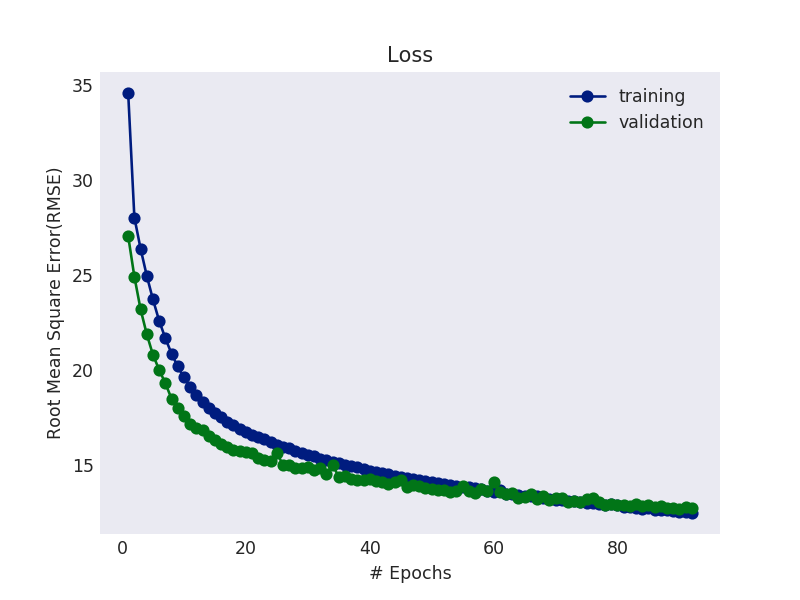

In [14]:
train_model(model, X_train, Y_train, test_fold=5, batch_size=64, max_epochs=100, name='vgg')

377/377 [==============================] - 2s 6ms/step
RMSE for Test data = 13.872588415331723


<IPython.core.display.Javascript object>


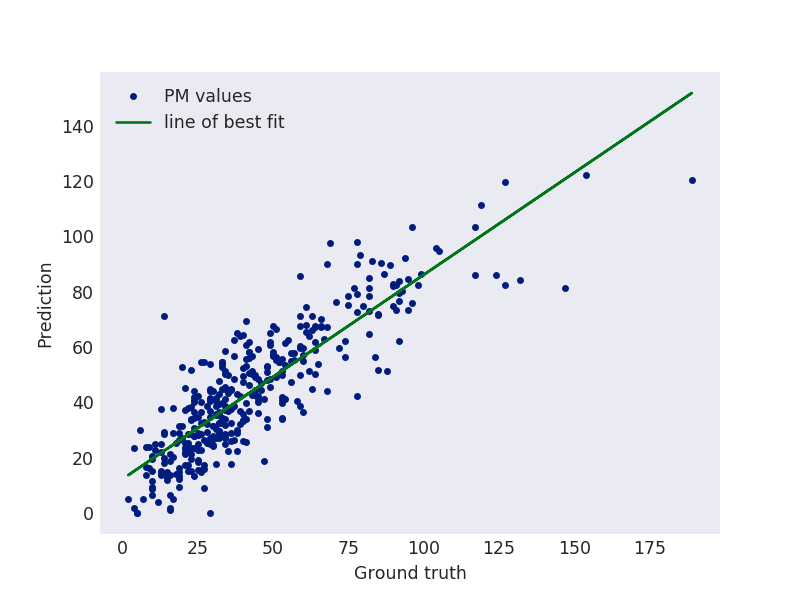

In [15]:
model_path="models/vgg_model5.h5"
evaluate_model(model_path, X_test, Y_test, Z_test, test_fold=5)

### Result

In [64]:
result_x=[]
result_y=[]
result_z=[]
name='vgg'
for i in range(5):
    eval_data=np.load('eval/{}_eval_data{}.npz'.format(name,i+1))
    for m in range(len(eval_data['x'])):
                   result_x.append(eval_data['x'][m])
                   result_y.append(eval_data['y'][m])
                   result_z.append(eval_data['z'][m])

result_x=np.array(result_x)
result_y=np.array(result_y)
result_z=np.array(result_z)

result = open('result_vgg16.csv', 'w')
result.write('Image_Name,Original_PM,Predicted_PM\n')
for i in range(len(x)):
        result.write('{},{},{:.2f}\n'.format(result_z[i], 
                                                     result_x[i], 
                                                     result_y[i]))
result.close()

In [65]:
def plot_result(x, y):
    m, b = np.polyfit(x, y, 1)
    plt.figure()
    plt.plot(x, y, '.', label="PM values")
    plt.plot(x, m*x + b, '-', label="Line of best fit")
    plt.legend(loc='upper left')
    plt.ylabel('Prediction')
    plt.xlabel('Ground truth')
    plt.grid(linestyle="--")
    plt.show()

def rmse(x,y):
    return np.sqrt(np.mean(np.square(x-y)))
       

def r_squared(x, y):
    SSE=np.sum(np.square(x-y))
    SST=np.sum(np.square(x - np.mean(x)))
    r_squared = 1-(SSE/SST)
    return r_squared

In [66]:
print("RMS Error = {:.3f}".format(rmse(result_x, result_y)))
print("R squared  = {:.3f}".format(r_squared(result_x, result_y)))
print("=================")
#plot_result(result_x, result_y)

RMS Error = 13.640
R squared  = 0.765


In [67]:
result_df=pd.read_csv('result_vgg16.csv')
#print(result_df.describe())
result_df.head()

Image_Name  Original_PM  Predicted_PM
0  201406091045.jpg         38.0         45.91
1  201405211400.jpg        125.0        115.40
2  201406291115.jpg         84.0         80.27
3  201405181100.jpg         32.0         26.59
4  201405061200.jpg         28.0         32.95

#### JointPlot

<IPython.core.display.Javascript object>


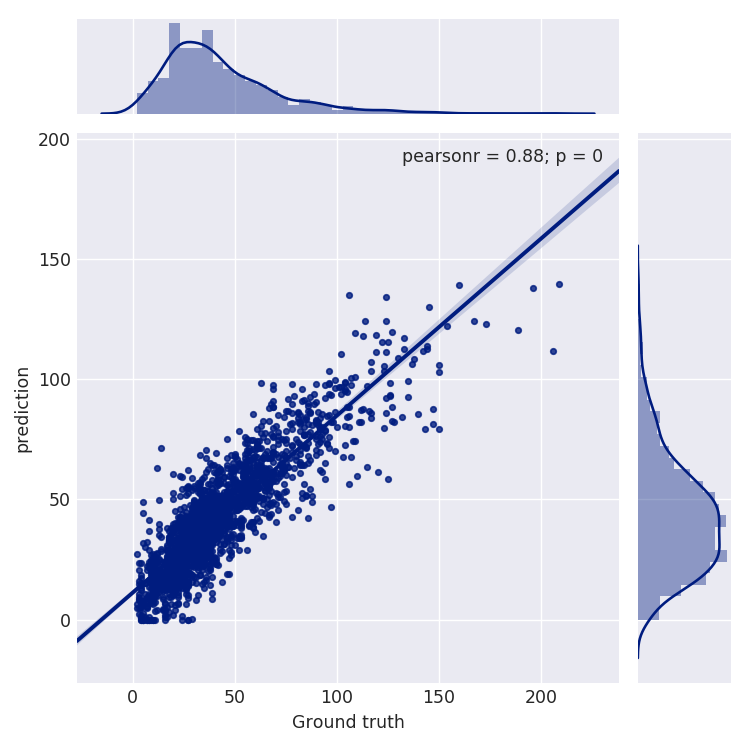

In [68]:
sns.jointplot(data=reult_df, x='Original_PM', y='Predicted_PM', kind='reg', scatter_kws={"s": 10}).set_axis_labels("Ground truth", "prediction")

### Distribution of Residuals

<IPython.core.display.Javascript object>


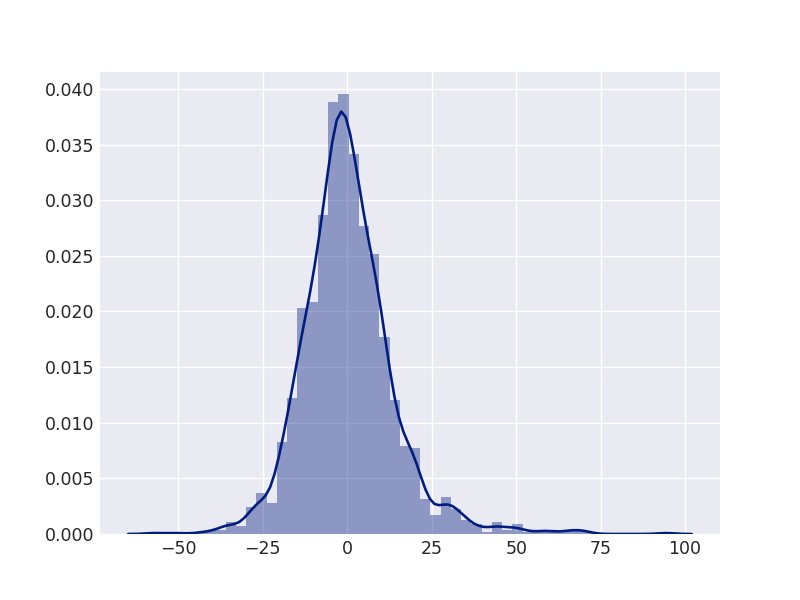

In [69]:
plt.figure()
sns.distplot(result_df['Original_PM']-result_df['Predicted_PM'])

### Some incorrect predictions

<IPython.core.display.Javascript object>


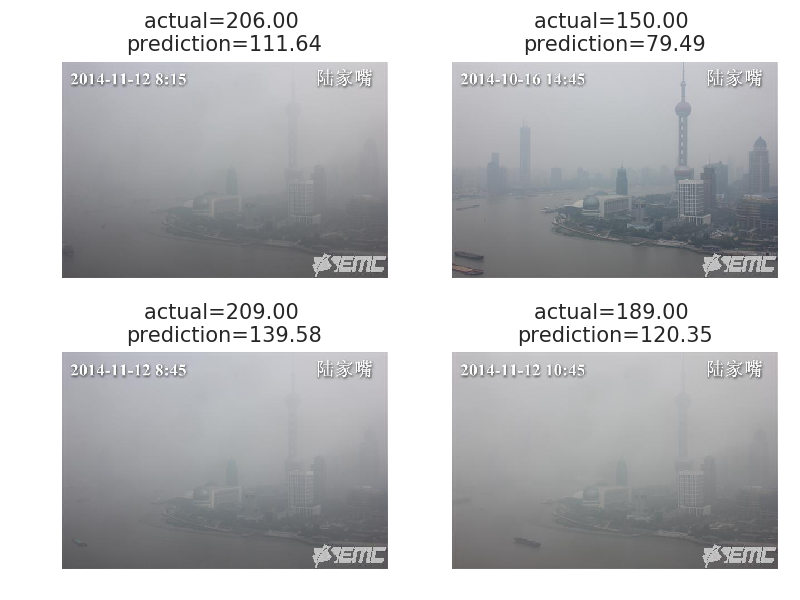

In [58]:
top_5_index=(result_df['Original_PM'] - result_df['Predicted_PM']).abs().nlargest(5).index.values
num_images=4

#Creating subplots of images from the dataset
fig=plt.figure()
for i in range(num_images):
    img=Image.open("images/{}".format(result_df["Image_Name"].values[top_5_index[i]]))
    ax=fig.add_subplot(math.ceil(num_images/2),2,i+1)
    ax.imshow(img)
    ax.set_title('actual={:0.2f} \nprediction={:0.2f}'.format(result_df['Original_PM'].values[top_5_index[i]], 
                                                     result_df['Predicted_PM'].values[top_5_index[i]]))
    ax.set_axis_off()
#automatically adjusts subplot params so that the subplot(s) fits in to the figure area.
fig.tight_layout()

### Some Correct Predictions

<IPython.core.display.Javascript object>


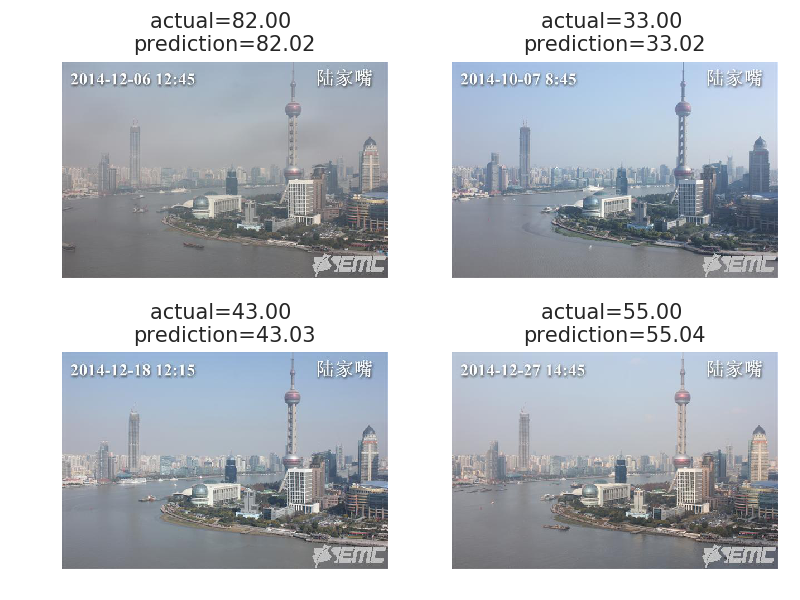

In [59]:
top_5_index=(result_df['Original_PM'] - result_df['Predicted_PM']).abs().nsmallest(5).index.values
num_images=4
#Creating subplots of images from the dataset
fig=plt.figure()
for i in range(num_images):
    img=Image.open("images/{}".format(result_df["Image_Name"].values[top_5_index[i]]))
    ax=fig.add_subplot(math.ceil(num_images/2),2,i+1)
    ax.imshow(img)
    ax.set_title('actual={:0.2f} \nprediction={:0.2f}'.format(result_df['Original_PM'].values[top_5_index[i]], 
                                                     result_df['Predicted_PM'].values[top_5_index[i]]))
    ax.set_axis_off()

fig.tight_layout()

### Resnet50 base model

In [8]:
(X_train, X_test, Y_train, Y_test, Z_train, Z_test)=load_data('resnet_data.npz')

In [9]:
model=resnet50()

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

### 1st fold as test set

Train on 2638 samples, validate on 189 samples


A Jupyter Widget

A Jupyter Widget

Epoch 1/100
2638/2638 [==============================] - 12s 5ms/step - loss: 1766.4858 - val_loss: 941.1316


A Jupyter Widget

Epoch 2/100
2638/2638 [==============================] - 10s 4ms/step - loss: 897.7602 - val_loss: 704.5086


A Jupyter Widget

Epoch 3/100
2638/2638 [==============================] - 10s 4ms/step - loss: 800.3952 - val_loss: 668.1499


A Jupyter Widget

Epoch 4/100
2638/2638 [==============================] - 10s 4ms/step - loss: 763.2568 - val_loss: 629.6168


A Jupyter Widget

Epoch 5/100
2638/2638 [==============================] - 10s 4ms/step - loss: 723.0474 - val_loss: 590.6150


A Jupyter Widget

Epoch 6/100
2638/2638 [==============================] - 10s 4ms/step - loss: 686.4658 - val_loss: 551.7632


A Jupyter Widget

Epoch 7/100
2638/2638 [==============================] - 10s 4ms/step - loss: 649.2431 - val_loss: 515.2154


A Jupyter Widget

Epoch 8/100
2638/2638 [==============================] - 10s 4ms/step - loss: 610.4423 - val_loss: 477.9776


A Jupyter Widget

Epoch 9/100
2638/2638 [==============================] - 10s 4ms/step - loss: 575.7518 - val_loss: 446.0571


A Jupyter Widget

Epoch 10/100
2638/2638 [==============================] - 10s 4ms/step - loss: 547.4083 - val_loss: 423.1730


A Jupyter Widget

Epoch 11/100
2638/2638 [==============================] - 10s 4ms/step - loss: 519.4567 - val_loss: 399.2549


A Jupyter Widget

Epoch 12/100
2638/2638 [==============================] - 10s 4ms/step - loss: 491.9507 - val_loss: 379.6341


A Jupyter Widget

Epoch 13/100
2638/2638 [==============================] - 10s 4ms/step - loss: 468.5680 - val_loss: 362.9857


A Jupyter Widget

Epoch 14/100
2638/2638 [==============================] - 10s 4ms/step - loss: 451.0410 - val_loss: 346.2074


A Jupyter Widget

Epoch 15/100
2638/2638 [==============================] - 10s 4ms/step - loss: 429.5779 - val_loss: 333.1791


A Jupyter Widget

Epoch 16/100
2638/2638 [==============================] - 10s 4ms/step - loss: 414.0552 - val_loss: 322.9432


A Jupyter Widget

Epoch 17/100
2638/2638 [==============================] - 10s 4ms/step - loss: 397.6342 - val_loss: 310.4623


A Jupyter Widget

Epoch 18/100
2638/2638 [==============================] - 10s 4ms/step - loss: 385.2951 - val_loss: 303.0045


A Jupyter Widget

Epoch 19/100
2638/2638 [==============================] - 10s 4ms/step - loss: 373.1961 - val_loss: 293.1624


A Jupyter Widget

Epoch 20/100
2638/2638 [==============================] - 10s 4ms/step - loss: 362.0380 - val_loss: 288.9815


A Jupyter Widget

Epoch 21/100
2638/2638 [==============================] - 10s 4ms/step - loss: 350.0787 - val_loss: 279.3460


A Jupyter Widget

Epoch 22/100
2638/2638 [==============================] - 10s 4ms/step - loss: 342.4600 - val_loss: 275.8864


A Jupyter Widget

Epoch 23/100
2638/2638 [==============================] - 10s 4ms/step - loss: 336.3537 - val_loss: 268.1462


A Jupyter Widget

Epoch 24/100
2638/2638 [==============================] - 10s 4ms/step - loss: 326.2521 - val_loss: 264.1420


A Jupyter Widget

Epoch 25/100
2638/2638 [==============================] - 10s 4ms/step - loss: 320.0858 - val_loss: 258.4839


A Jupyter Widget

Epoch 26/100
2638/2638 [==============================] - 10s 4ms/step - loss: 311.0922 - val_loss: 258.3696


A Jupyter Widget

Epoch 27/100
2638/2638 [==============================] - 10s 4ms/step - loss: 308.3841 - val_loss: 250.6952


A Jupyter Widget

Epoch 28/100
2638/2638 [==============================] - 10s 4ms/step - loss: 297.6627 - val_loss: 249.0376


A Jupyter Widget

Epoch 29/100
2638/2638 [==============================] - 10s 4ms/step - loss: 296.6500 - val_loss: 245.6106


A Jupyter Widget

Epoch 30/100
2638/2638 [==============================] - 10s 4ms/step - loss: 291.5832 - val_loss: 241.6113


A Jupyter Widget

Epoch 31/100
2638/2638 [==============================] - 10s 4ms/step - loss: 290.5409 - val_loss: 237.3461


A Jupyter Widget

Epoch 32/100
2638/2638 [==============================] - 10s 4ms/step - loss: 279.3823 - val_loss: 236.5715


A Jupyter Widget

Epoch 33/100
2638/2638 [==============================] - 10s 4ms/step - loss: 276.0780 - val_loss: 233.0000


A Jupyter Widget

Epoch 34/100
2638/2638 [==============================] - 10s 4ms/step - loss: 275.4347 - val_loss: 231.1860


A Jupyter Widget

Epoch 35/100
2638/2638 [==============================] - 9s 4ms/step - loss: 269.7616 - val_loss: 231.5335


A Jupyter Widget

Epoch 36/100
2638/2638 [==============================] - 10s 4ms/step - loss: 270.7137 - val_loss: 229.5652


A Jupyter Widget

Epoch 37/100
2638/2638 [==============================] - 10s 4ms/step - loss: 263.1712 - val_loss: 226.2810


A Jupyter Widget

Epoch 38/100
2638/2638 [==============================] - 10s 4ms/step - loss: 265.7077 - val_loss: 222.2248


A Jupyter Widget

Epoch 39/100
2638/2638 [==============================] - 9s 4ms/step - loss: 257.2605 - val_loss: 223.6467


A Jupyter Widget

Epoch 40/100
2638/2638 [==============================] - 10s 4ms/step - loss: 261.1981 - val_loss: 218.1050


A Jupyter Widget

Epoch 41/100
2638/2638 [==============================] - 10s 4ms/step - loss: 251.6057 - val_loss: 217.6164


A Jupyter Widget

Epoch 42/100
2638/2638 [==============================] - 10s 4ms/step - loss: 255.3372 - val_loss: 222.2714


A Jupyter Widget

Epoch 43/100
2638/2638 [==============================] - 10s 4ms/step - loss: 243.9820 - val_loss: 212.5140


A Jupyter Widget

Epoch 44/100
2638/2638 [==============================] - 10s 4ms/step - loss: 243.8837 - val_loss: 211.0390


A Jupyter Widget

Epoch 45/100
2638/2638 [==============================] - 10s 4ms/step - loss: 244.4445 - val_loss: 210.2059


A Jupyter Widget

Epoch 46/100
2638/2638 [==============================] - 9s 4ms/step - loss: 240.7469 - val_loss: 211.1604


A Jupyter Widget

Epoch 47/100
2638/2638 [==============================] - 10s 4ms/step - loss: 240.5398 - val_loss: 206.0678


A Jupyter Widget

Epoch 48/100
2638/2638 [==============================] - 9s 4ms/step - loss: 233.7993 - val_loss: 206.4576


A Jupyter Widget

Epoch 49/100
2638/2638 [==============================] - 10s 4ms/step - loss: 236.0224 - val_loss: 211.4362


A Jupyter Widget

Epoch 50/100
2638/2638 [==============================] - 10s 4ms/step - loss: 244.0007 - val_loss: 203.4907


A Jupyter Widget

Epoch 51/100
2638/2638 [==============================] - 10s 4ms/step - loss: 231.7051 - val_loss: 202.3039


A Jupyter Widget

Epoch 52/100
2638/2638 [==============================] - 10s 4ms/step - loss: 228.2235 - val_loss: 200.1845


A Jupyter Widget

Epoch 53/100
2638/2638 [==============================] - 10s 4ms/step - loss: 223.6591 - val_loss: 198.9321


A Jupyter Widget

Epoch 54/100
2638/2638 [==============================] - 10s 4ms/step - loss: 225.2042 - val_loss: 196.9948


A Jupyter Widget

Epoch 55/100
2638/2638 [==============================] - 9s 4ms/step - loss: 225.7238 - val_loss: 203.6598


A Jupyter Widget

Epoch 56/100
2638/2638 [==============================] - 10s 4ms/step - loss: 219.5611 - val_loss: 199.4292


A Jupyter Widget

Epoch 57/100
2638/2638 [==============================] - 10s 4ms/step - loss: 221.3614 - val_loss: 195.4195


A Jupyter Widget

Epoch 58/100
2638/2638 [==============================] - 10s 4ms/step - loss: 219.7263 - val_loss: 195.5677


A Jupyter Widget

Epoch 59/100
2638/2638 [==============================] - 10s 4ms/step - loss: 213.5876 - val_loss: 194.4624


A Jupyter Widget

Epoch 60/100
2638/2638 [==============================] - 10s 4ms/step - loss: 221.8929 - val_loss: 191.3772


A Jupyter Widget

Epoch 61/100
2638/2638 [==============================] - 9s 4ms/step - loss: 209.4482 - val_loss: 195.3753


A Jupyter Widget

Epoch 62/100
2638/2638 [==============================] - 10s 4ms/step - loss: 215.8814 - val_loss: 190.4646


A Jupyter Widget

Epoch 63/100
2638/2638 [==============================] - 10s 4ms/step - loss: 207.4779 - val_loss: 189.3256


A Jupyter Widget

Epoch 64/100
2638/2638 [==============================] - 9s 4ms/step - loss: 207.7050 - val_loss: 190.9394


A Jupyter Widget

Epoch 65/100
2638/2638 [==============================] - 10s 4ms/step - loss: 208.4343 - val_loss: 189.2383


A Jupyter Widget

Epoch 66/100
2638/2638 [==============================] - 10s 4ms/step - loss: 210.1582 - val_loss: 187.4226


A Jupyter Widget

Epoch 67/100
2638/2638 [==============================] - 9s 4ms/step - loss: 206.9239 - val_loss: 189.8309


A Jupyter Widget

Epoch 68/100
2638/2638 [==============================] - 10s 4ms/step - loss: 209.9942 - val_loss: 187.8519


A Jupyter Widget

Epoch 69/100
2638/2638 [==============================] - 10s 4ms/step - loss: 202.5717 - val_loss: 185.0592


A Jupyter Widget

Epoch 70/100
2638/2638 [==============================] - 10s 4ms/step - loss: 205.9774 - val_loss: 190.1454


A Jupyter Widget

Epoch 71/100
2638/2638 [==============================] - 10s 4ms/step - loss: 195.6848 - val_loss: 184.2798


A Jupyter Widget

Epoch 72/100
2638/2638 [==============================] - 10s 4ms/step - loss: 206.2635 - val_loss: 183.4578


A Jupyter Widget

Epoch 73/100
2638/2638 [==============================] - 9s 4ms/step - loss: 199.4942 - val_loss: 189.6779


A Jupyter Widget

Epoch 74/100
2638/2638 [==============================] - 10s 4ms/step - loss: 204.1360 - val_loss: 184.1486


A Jupyter Widget

Epoch 75/100
2638/2638 [==============================] - 10s 4ms/step - loss: 204.6793 - val_loss: 183.4545


A Jupyter Widget

Epoch 76/100
2638/2638 [==============================] - 10s 4ms/step - loss: 196.1440 - val_loss: 180.6149


A Jupyter Widget

Epoch 77/100
2638/2638 [==============================] - 10s 4ms/step - loss: 194.1459 - val_loss: 180.2640


A Jupyter Widget

Epoch 78/100
2638/2638 [==============================] - 9s 3ms/step - loss: 198.3554 - val_loss: 183.7542


A Jupyter Widget

Epoch 79/100
2638/2638 [==============================] - 9s 3ms/step - loss: 192.0502 - val_loss: 180.7348


A Jupyter Widget

Epoch 80/100
2638/2638 [==============================] - 9s 3ms/step - loss: 194.4422 - val_loss: 183.4725


A Jupyter Widget

Epoch 81/100
2638/2638 [==============================] - 9s 3ms/step - loss: 192.4641 - val_loss: 183.4570
Epoch 00081: early stopping



<IPython.core.display.Javascript object>


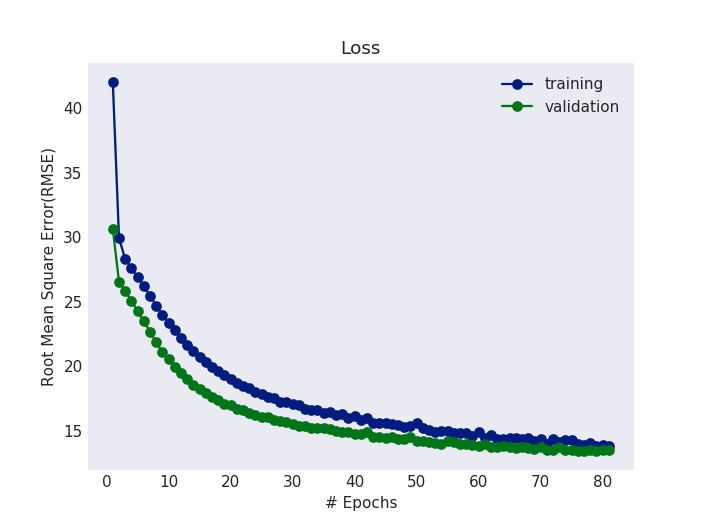

In [11]:
train_model(model, X_train, Y_train, test_fold=1, batch_size=64, max_epochs=100, name='resnet')

377/377 [==============================] - 2s 4ms/step
RMSE for Test data = 12.760635305963559


<IPython.core.display.Javascript object>


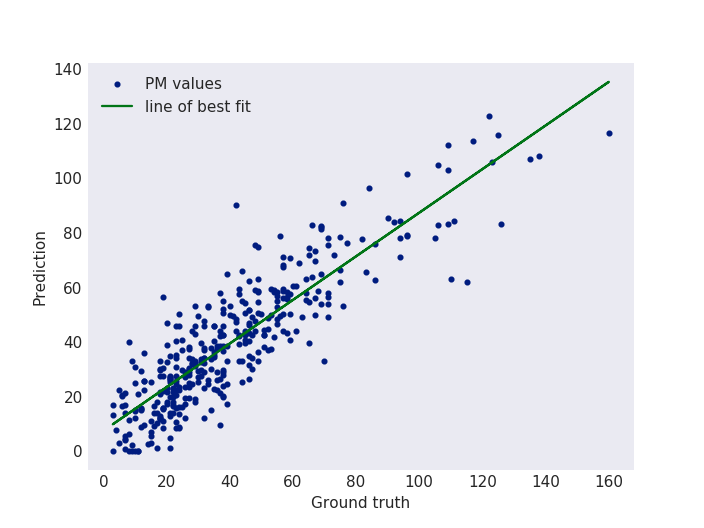

In [12]:
model_path="models/resnet_model1.h5"
evaluate_model(model_path, X_test, Y_test, Z_test, test_fold=1, name='resnet')

### 2nd fold as test set

Train on 2638 samples, validate on 189 samples


A Jupyter Widget

A Jupyter Widget

Epoch 1/100
2638/2638 [==============================] - 12s 5ms/step - loss: 1503.0093 - val_loss: 1567.0039


A Jupyter Widget

Epoch 2/100
2638/2638 [==============================] - 10s 4ms/step - loss: 722.1009 - val_loss: 1226.1958


A Jupyter Widget

Epoch 3/100
2638/2638 [==============================] - 10s 4ms/step - loss: 652.1997 - val_loss: 1142.0318


A Jupyter Widget

Epoch 4/100
2638/2638 [==============================] - 10s 4ms/step - loss: 619.2484 - val_loss: 1064.0238


A Jupyter Widget

Epoch 5/100
2638/2638 [==============================] - 10s 4ms/step - loss: 586.8883 - val_loss: 985.4489


A Jupyter Widget

Epoch 6/100
2638/2638 [==============================] - 10s 4ms/step - loss: 550.7785 - val_loss: 913.0344


A Jupyter Widget

Epoch 7/100
2638/2638 [==============================] - 10s 4ms/step - loss: 518.2637 - val_loss: 850.6796


A Jupyter Widget

Epoch 8/100
2638/2638 [==============================] - 10s 4ms/step - loss: 487.8798 - val_loss: 798.4036


A Jupyter Widget

Epoch 9/100
2638/2638 [==============================] - 10s 4ms/step - loss: 461.2822 - val_loss: 753.5989


A Jupyter Widget

Epoch 10/100
2638/2638 [==============================] - 10s 4ms/step - loss: 435.3471 - val_loss: 717.9199


A Jupyter Widget

Epoch 11/100
2638/2638 [==============================] - 10s 4ms/step - loss: 416.4956 - val_loss: 680.1533


A Jupyter Widget

Epoch 12/100
2638/2638 [==============================] - 10s 4ms/step - loss: 394.1491 - val_loss: 647.5043


A Jupyter Widget

Epoch 13/100
2638/2638 [==============================] - 10s 4ms/step - loss: 375.4772 - val_loss: 618.0859


A Jupyter Widget

Epoch 14/100
2638/2638 [==============================] - 10s 4ms/step - loss: 358.6908 - val_loss: 596.1364


A Jupyter Widget

Epoch 15/100
2638/2638 [==============================] - 10s 4ms/step - loss: 343.8006 - val_loss: 570.7639


A Jupyter Widget

Epoch 16/100
2638/2638 [==============================] - 10s 4ms/step - loss: 329.5401 - val_loss: 551.0925


A Jupyter Widget

Epoch 17/100
2638/2638 [==============================] - 10s 4ms/step - loss: 321.1539 - val_loss: 528.5661


A Jupyter Widget

Epoch 18/100
2638/2638 [==============================] - 10s 4ms/step - loss: 309.4069 - val_loss: 518.8666


A Jupyter Widget

Epoch 19/100
2638/2638 [==============================] - 10s 4ms/step - loss: 301.2366 - val_loss: 492.7533


A Jupyter Widget

Epoch 20/100
2638/2638 [==============================] - 10s 4ms/step - loss: 296.3938 - val_loss: 482.1179


A Jupyter Widget

Epoch 21/100
2638/2638 [==============================] - 10s 4ms/step - loss: 284.7328 - val_loss: 472.0812


A Jupyter Widget

Epoch 22/100
2638/2638 [==============================] - 10s 4ms/step - loss: 277.6148 - val_loss: 459.1001


A Jupyter Widget

Epoch 23/100
2638/2638 [==============================] - 10s 4ms/step - loss: 269.3955 - val_loss: 449.5412


A Jupyter Widget

Epoch 24/100
2638/2638 [==============================] - 10s 4ms/step - loss: 267.3238 - val_loss: 438.1676


A Jupyter Widget

Epoch 25/100
2638/2638 [==============================] - 9s 4ms/step - loss: 262.1114 - val_loss: 442.5987


A Jupyter Widget

Epoch 26/100
2638/2638 [==============================] - 10s 4ms/step - loss: 255.2942 - val_loss: 423.3496


A Jupyter Widget

Epoch 27/100
2638/2638 [==============================] - 10s 4ms/step - loss: 250.7700 - val_loss: 414.1967


A Jupyter Widget

Epoch 28/100
2638/2638 [==============================] - 10s 4ms/step - loss: 246.8199 - val_loss: 410.5643


A Jupyter Widget

Epoch 29/100
2638/2638 [==============================] - 10s 4ms/step - loss: 241.3536 - val_loss: 396.1339


A Jupyter Widget

Epoch 30/100
2638/2638 [==============================] - 10s 4ms/step - loss: 237.1615 - val_loss: 391.7734


A Jupyter Widget

Epoch 31/100
2638/2638 [==============================] - 9s 4ms/step - loss: 235.4647 - val_loss: 394.8802


A Jupyter Widget

Epoch 32/100
2638/2638 [==============================] - 10s 4ms/step - loss: 231.9513 - val_loss: 386.4911


A Jupyter Widget

Epoch 33/100
2638/2638 [==============================] - 10s 4ms/step - loss: 235.5634 - val_loss: 372.9627


A Jupyter Widget

Epoch 34/100
2638/2638 [==============================] - 9s 4ms/step - loss: 228.8571 - val_loss: 376.7638


A Jupyter Widget

Epoch 35/100
2638/2638 [==============================] - 9s 4ms/step - loss: 222.6027 - val_loss: 373.7850


A Jupyter Widget

Epoch 36/100
2638/2638 [==============================] - 10s 4ms/step - loss: 226.7369 - val_loss: 358.9230


A Jupyter Widget

Epoch 37/100
2638/2638 [==============================] - 10s 4ms/step - loss: 217.8502 - val_loss: 358.3369


A Jupyter Widget

Epoch 38/100
2638/2638 [==============================] - 9s 4ms/step - loss: 215.4075 - val_loss: 364.1778


A Jupyter Widget

Epoch 39/100
2638/2638 [==============================] - 10s 4ms/step - loss: 216.5961 - val_loss: 353.2146


A Jupyter Widget

Epoch 40/100
2638/2638 [==============================] - 10s 4ms/step - loss: 210.6001 - val_loss: 350.4819


A Jupyter Widget

Epoch 41/100
2638/2638 [==============================] - 10s 4ms/step - loss: 209.9253 - val_loss: 340.5137


A Jupyter Widget

Epoch 42/100
2638/2638 [==============================] - 10s 4ms/step - loss: 209.8397 - val_loss: 341.8610


A Jupyter Widget

Epoch 43/100
2638/2638 [==============================] - 10s 4ms/step - loss: 202.1501 - val_loss: 336.7994


A Jupyter Widget

Epoch 44/100
2638/2638 [==============================] - 10s 4ms/step - loss: 202.4471 - val_loss: 336.3232


A Jupyter Widget

Epoch 45/100
2638/2638 [==============================] - 10s 4ms/step - loss: 204.8964 - val_loss: 334.8603


A Jupyter Widget

Epoch 46/100
2638/2638 [==============================] - 10s 4ms/step - loss: 200.3809 - val_loss: 326.7224


A Jupyter Widget

Epoch 47/100
2638/2638 [==============================] - 10s 4ms/step - loss: 199.8261 - val_loss: 326.1500


A Jupyter Widget

Epoch 48/100
2638/2638 [==============================] - 10s 4ms/step - loss: 199.6467 - val_loss: 323.2963


A Jupyter Widget

Epoch 49/100
2638/2638 [==============================] - 9s 4ms/step - loss: 199.2398 - val_loss: 323.4546


A Jupyter Widget

Epoch 50/100
2638/2638 [==============================] - 10s 4ms/step - loss: 190.1744 - val_loss: 320.4759


A Jupyter Widget

Epoch 51/100
2638/2638 [==============================] - 10s 4ms/step - loss: 191.0248 - val_loss: 320.8287


A Jupyter Widget

Epoch 52/100
2638/2638 [==============================] - 10s 4ms/step - loss: 192.6893 - val_loss: 318.4764


A Jupyter Widget

Epoch 53/100
2638/2638 [==============================] - 10s 4ms/step - loss: 186.3008 - val_loss: 313.4319


A Jupyter Widget

Epoch 54/100
2638/2638 [==============================] - 9s 4ms/step - loss: 187.1891 - val_loss: 319.0679


A Jupyter Widget

Epoch 55/100
2638/2638 [==============================] - 10s 4ms/step - loss: 186.9329 - val_loss: 308.2902


A Jupyter Widget

Epoch 56/100
2638/2638 [==============================] - 10s 4ms/step - loss: 187.4353 - val_loss: 305.7813


A Jupyter Widget

Epoch 57/100
2638/2638 [==============================] - 9s 4ms/step - loss: 179.9939 - val_loss: 306.0621


A Jupyter Widget

Epoch 58/100
2638/2638 [==============================] - 9s 4ms/step - loss: 183.8913 - val_loss: 313.5738


A Jupyter Widget

Epoch 59/100
2638/2638 [==============================] - 10s 4ms/step - loss: 184.8986 - val_loss: 303.3669


A Jupyter Widget

Epoch 60/100
2638/2638 [==============================] - 10s 4ms/step - loss: 180.0520 - val_loss: 298.8607


A Jupyter Widget

Epoch 61/100
2638/2638 [==============================] - 9s 4ms/step - loss: 178.9976 - val_loss: 304.6304


A Jupyter Widget

Epoch 62/100
2638/2638 [==============================] - 10s 4ms/step - loss: 176.0998 - val_loss: 297.7598


A Jupyter Widget

Epoch 63/100
2638/2638 [==============================] - 10s 4ms/step - loss: 176.7231 - val_loss: 293.2370


A Jupyter Widget

Epoch 64/100
2638/2638 [==============================] - 10s 4ms/step - loss: 175.3187 - val_loss: 307.7346


A Jupyter Widget

Epoch 65/100
2638/2638 [==============================] - 9s 4ms/step - loss: 178.0068 - val_loss: 303.4030


A Jupyter Widget

Epoch 66/100
2638/2638 [==============================] - 10s 4ms/step - loss: 178.8604 - val_loss: 292.8882


A Jupyter Widget

Epoch 67/100
2638/2638 [==============================] - 10s 4ms/step - loss: 170.6508 - val_loss: 283.9818


A Jupyter Widget

Epoch 68/100
2638/2638 [==============================] - 10s 4ms/step - loss: 172.0218 - val_loss: 290.0493


A Jupyter Widget

Epoch 69/100
2638/2638 [==============================] - 10s 4ms/step - loss: 168.2190 - val_loss: 292.1569


A Jupyter Widget

Epoch 70/100
2638/2638 [==============================] - 10s 4ms/step - loss: 167.5331 - val_loss: 289.3449


A Jupyter Widget

Epoch 71/100
2638/2638 [==============================] - 10s 4ms/step - loss: 165.8586 - val_loss: 288.0962


A Jupyter Widget

Epoch 72/100
2638/2638 [==============================] - 10s 4ms/step - loss: 167.0535 - val_loss: 280.5642


A Jupyter Widget

Epoch 73/100
2638/2638 [==============================] - 10s 4ms/step - loss: 169.3028 - val_loss: 283.2890


A Jupyter Widget

Epoch 74/100
2638/2638 [==============================] - 10s 4ms/step - loss: 163.7498 - val_loss: 295.8482


A Jupyter Widget

Epoch 75/100
2638/2638 [==============================] - 10s 4ms/step - loss: 166.3509 - val_loss: 276.9454


A Jupyter Widget

Epoch 76/100
2638/2638 [==============================] - 10s 4ms/step - loss: 166.0766 - val_loss: 278.8845


A Jupyter Widget

Epoch 77/100
2638/2638 [==============================] - 10s 4ms/step - loss: 161.8769 - val_loss: 276.5818


A Jupyter Widget

Epoch 78/100
2638/2638 [==============================] - 10s 4ms/step - loss: 160.1944 - val_loss: 274.7453


A Jupyter Widget

Epoch 79/100
2638/2638 [==============================] - 10s 4ms/step - loss: 160.3728 - val_loss: 285.0016


A Jupyter Widget

Epoch 80/100
2638/2638 [==============================] - 10s 4ms/step - loss: 162.3116 - val_loss: 274.2814


A Jupyter Widget

Epoch 81/100
2638/2638 [==============================] - 10s 4ms/step - loss: 163.6313 - val_loss: 276.9385


A Jupyter Widget

Epoch 82/100
2638/2638 [==============================] - 10s 4ms/step - loss: 159.2321 - val_loss: 277.8759


A Jupyter Widget

Epoch 83/100
2638/2638 [==============================] - 10s 4ms/step - loss: 156.2535 - val_loss: 267.8408


A Jupyter Widget

Epoch 84/100
2638/2638 [==============================] - 10s 4ms/step - loss: 164.3861 - val_loss: 272.0590


A Jupyter Widget

Epoch 85/100
2638/2638 [==============================] - 9s 4ms/step - loss: 155.6667 - val_loss: 275.3424


A Jupyter Widget

Epoch 86/100
2638/2638 [==============================] - 10s 4ms/step - loss: 154.6135 - val_loss: 269.7746


A Jupyter Widget

Epoch 87/100
2638/2638 [==============================] - 10s 4ms/step - loss: 153.0234 - val_loss: 277.9394


A Jupyter Widget

Epoch 88/100
2638/2638 [==============================] - 10s 4ms/step - loss: 155.7039 - val_loss: 264.5873


A Jupyter Widget

Epoch 89/100
2638/2638 [==============================] - 10s 4ms/step - loss: 151.5159 - val_loss: 269.9697


A Jupyter Widget

Epoch 90/100
2638/2638 [==============================] - 10s 4ms/step - loss: 157.3161 - val_loss: 280.9359


A Jupyter Widget

Epoch 91/100
2638/2638 [==============================] - 10s 4ms/step - loss: 152.7457 - val_loss: 278.7075


A Jupyter Widget

Epoch 92/100
2638/2638 [==============================] - 10s 4ms/step - loss: 154.1091 - val_loss: 271.6659


A Jupyter Widget

Epoch 93/100
2638/2638 [==============================] - 10s 4ms/step - loss: 149.7682 - val_loss: 271.3395
Epoch 00093: early stopping



<IPython.core.display.Javascript object>


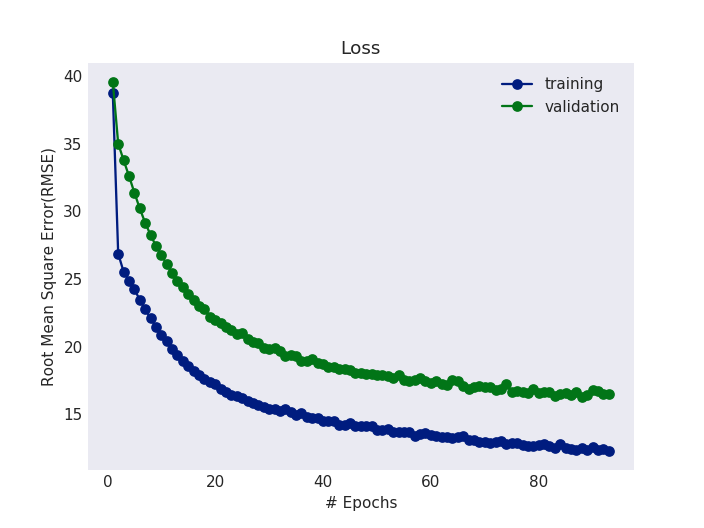

In [10]:
train_model(model, X_train, Y_train, test_fold=2, batch_size=64, max_epochs=100, name='resnet')

377/377 [==============================] - 2s 4ms/step
RMSE for Test data = 16.04321960279549


<IPython.core.display.Javascript object>


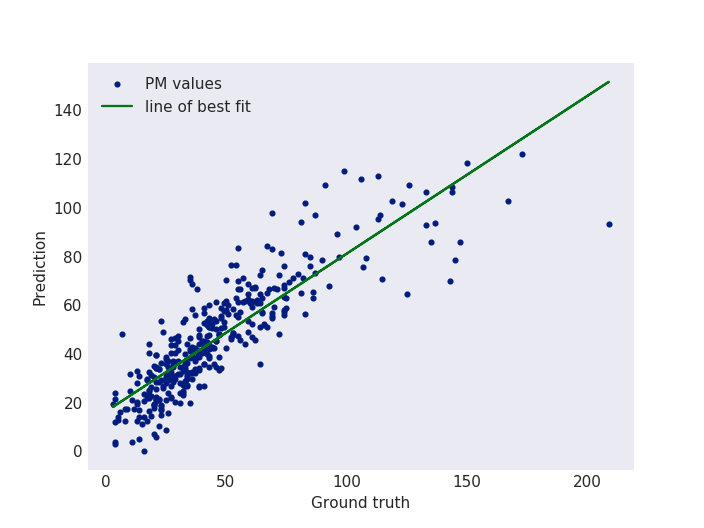

In [11]:
model_path="models/resnet_model2.h5"
evaluate_model(model_path, X_test, Y_test, Z_test, test_fold=2, name='resnet')

### 3rd fold as test set

Train on 2638 samples, validate on 189 samples


A Jupyter Widget

A Jupyter Widget

Epoch 1/100
2638/2638 [==============================] - 12s 5ms/step - loss: 1753.8608 - val_loss: 813.1646


A Jupyter Widget

Epoch 2/100
2638/2638 [==============================] - 10s 4ms/step - loss: 890.5279 - val_loss: 607.3988


A Jupyter Widget

Epoch 3/100
2638/2638 [==============================] - 10s 4ms/step - loss: 797.4265 - val_loss: 579.2979


A Jupyter Widget

Epoch 4/100
2638/2638 [==============================] - 10s 4ms/step - loss: 756.9923 - val_loss: 540.8429


A Jupyter Widget

Epoch 5/100
2638/2638 [==============================] - 10s 4ms/step - loss: 720.0903 - val_loss: 500.5889


A Jupyter Widget

Epoch 6/100
2638/2638 [==============================] - 10s 4ms/step - loss: 681.5512 - val_loss: 462.7559


A Jupyter Widget

Epoch 7/100
2638/2638 [==============================] - 10s 4ms/step - loss: 643.4999 - val_loss: 426.2989


A Jupyter Widget

Epoch 8/100
2638/2638 [==============================] - 10s 4ms/step - loss: 609.1028 - val_loss: 395.7016


A Jupyter Widget

Epoch 9/100
2638/2638 [==============================] - 10s 4ms/step - loss: 579.6064 - val_loss: 361.8097


A Jupyter Widget

Epoch 10/100
2638/2638 [==============================] - 10s 4ms/step - loss: 545.2466 - val_loss: 336.0341


A Jupyter Widget

Epoch 11/100
2638/2638 [==============================] - 10s 4ms/step - loss: 517.1280 - val_loss: 313.8307


A Jupyter Widget

Epoch 12/100
2638/2638 [==============================] - 10s 4ms/step - loss: 493.9444 - val_loss: 293.8296


A Jupyter Widget

Epoch 13/100
2638/2638 [==============================] - 10s 4ms/step - loss: 469.8605 - val_loss: 280.0325


A Jupyter Widget

Epoch 14/100
2638/2638 [==============================] - 10s 4ms/step - loss: 445.8329 - val_loss: 262.4131


A Jupyter Widget

Epoch 15/100
2638/2638 [==============================] - 10s 4ms/step - loss: 435.6299 - val_loss: 248.9269


A Jupyter Widget

Epoch 16/100
2638/2638 [==============================] - 10s 4ms/step - loss: 412.9804 - val_loss: 241.4418


A Jupyter Widget

Epoch 17/100
2638/2638 [==============================] - 10s 4ms/step - loss: 398.0782 - val_loss: 235.3457


A Jupyter Widget

Epoch 18/100
2638/2638 [==============================] - 10s 4ms/step - loss: 381.6396 - val_loss: 224.5491


A Jupyter Widget

Epoch 19/100
2638/2638 [==============================] - 10s 4ms/step - loss: 374.8054 - val_loss: 218.3199


A Jupyter Widget

Epoch 20/100
2638/2638 [==============================] - 10s 4ms/step - loss: 360.9717 - val_loss: 211.5017


A Jupyter Widget

Epoch 21/100
2638/2638 [==============================] - 9s 4ms/step - loss: 348.5336 - val_loss: 214.9500


A Jupyter Widget

Epoch 22/100
2638/2638 [==============================] - 10s 4ms/step - loss: 343.7411 - val_loss: 201.2201


A Jupyter Widget

Epoch 23/100
2638/2638 [==============================] - 10s 4ms/step - loss: 338.6271 - val_loss: 200.0067


A Jupyter Widget

Epoch 24/100
2638/2638 [==============================] - 9s 4ms/step - loss: 327.7799 - val_loss: 203.6120


A Jupyter Widget

Epoch 25/100
2638/2638 [==============================] - 10s 4ms/step - loss: 322.0122 - val_loss: 193.3731


A Jupyter Widget

Epoch 26/100
2638/2638 [==============================] - 10s 4ms/step - loss: 307.8823 - val_loss: 188.1719


A Jupyter Widget

Epoch 27/100
2638/2638 [==============================] - 10s 4ms/step - loss: 305.7686 - val_loss: 187.9524


A Jupyter Widget

Epoch 28/100
2638/2638 [==============================] - 9s 4ms/step - loss: 301.8121 - val_loss: 190.0885


A Jupyter Widget

Epoch 29/100
2638/2638 [==============================] - 10s 4ms/step - loss: 296.3550 - val_loss: 181.0353


A Jupyter Widget

Epoch 30/100
2638/2638 [==============================] - 9s 4ms/step - loss: 285.6136 - val_loss: 186.9346


A Jupyter Widget

Epoch 31/100
2638/2638 [==============================] - 10s 4ms/step - loss: 281.5612 - val_loss: 181.5548


A Jupyter Widget

Epoch 32/100
2638/2638 [==============================] - 10s 4ms/step - loss: 282.6213 - val_loss: 188.9480


A Jupyter Widget

Epoch 33/100
2638/2638 [==============================] - 10s 4ms/step - loss: 275.8016 - val_loss: 176.9344


A Jupyter Widget

Epoch 34/100
2638/2638 [==============================] - 10s 4ms/step - loss: 274.0136 - val_loss: 175.8662


A Jupyter Widget

Epoch 35/100
2638/2638 [==============================] - 9s 4ms/step - loss: 270.7144 - val_loss: 176.3167


A Jupyter Widget

Epoch 36/100
2638/2638 [==============================] - 10s 4ms/step - loss: 265.1319 - val_loss: 178.6674


A Jupyter Widget

Epoch 37/100
2638/2638 [==============================] - 10s 4ms/step - loss: 266.6851 - val_loss: 169.6064


A Jupyter Widget

Epoch 38/100
2638/2638 [==============================] - 10s 4ms/step - loss: 262.9935 - val_loss: 168.6923


A Jupyter Widget

Epoch 39/100
2638/2638 [==============================] - 10s 4ms/step - loss: 255.2911 - val_loss: 169.7074


A Jupyter Widget

Epoch 40/100
2638/2638 [==============================] - 10s 4ms/step - loss: 254.2870 - val_loss: 168.1980


A Jupyter Widget

Epoch 41/100
2638/2638 [==============================] - 10s 4ms/step - loss: 252.8962 - val_loss: 165.4680


A Jupyter Widget

Epoch 42/100
2638/2638 [==============================] - 9s 4ms/step - loss: 249.9356 - val_loss: 166.4868


A Jupyter Widget

Epoch 43/100
2638/2638 [==============================] - 10s 4ms/step - loss: 248.7728 - val_loss: 165.0251


A Jupyter Widget

Epoch 44/100
2638/2638 [==============================] - 10s 4ms/step - loss: 241.0812 - val_loss: 164.1010


A Jupyter Widget

Epoch 45/100
2638/2638 [==============================] - 10s 4ms/step - loss: 249.8458 - val_loss: 163.3529


A Jupyter Widget

Epoch 46/100
2638/2638 [==============================] - 10s 4ms/step - loss: 240.2998 - val_loss: 164.9204


A Jupyter Widget

Epoch 47/100
2638/2638 [==============================] - 9s 4ms/step - loss: 235.3457 - val_loss: 165.1667


A Jupyter Widget

Epoch 48/100
2638/2638 [==============================] - 9s 4ms/step - loss: 232.9138 - val_loss: 166.7263


A Jupyter Widget

Epoch 49/100
2638/2638 [==============================] - 10s 4ms/step - loss: 230.3244 - val_loss: 162.3727


A Jupyter Widget

Epoch 50/100
2638/2638 [==============================] - 10s 4ms/step - loss: 228.9270 - val_loss: 161.6682


A Jupyter Widget

Epoch 51/100
2638/2638 [==============================] - 10s 4ms/step - loss: 226.0092 - val_loss: 162.9863


A Jupyter Widget

Epoch 52/100
2638/2638 [==============================] - 10s 4ms/step - loss: 231.3827 - val_loss: 160.5312


A Jupyter Widget

Epoch 53/100
2638/2638 [==============================] - 10s 4ms/step - loss: 226.8497 - val_loss: 159.8169


A Jupyter Widget

Epoch 54/100
2638/2638 [==============================] - 10s 4ms/step - loss: 226.1449 - val_loss: 156.8323


A Jupyter Widget

Epoch 55/100
2638/2638 [==============================] - 10s 4ms/step - loss: 215.5824 - val_loss: 160.2318


A Jupyter Widget

Epoch 56/100
2638/2638 [==============================] - 10s 4ms/step - loss: 215.9976 - val_loss: 155.9916


A Jupyter Widget

Epoch 57/100
2638/2638 [==============================] - 10s 4ms/step - loss: 214.7994 - val_loss: 165.0760


A Jupyter Widget

Epoch 58/100
2638/2638 [==============================] - 10s 4ms/step - loss: 209.2347 - val_loss: 155.6401


A Jupyter Widget

Epoch 59/100
2638/2638 [==============================] - 9s 4ms/step - loss: 213.5139 - val_loss: 156.2848


A Jupyter Widget

Epoch 60/100
2638/2638 [==============================] - 10s 4ms/step - loss: 213.1997 - val_loss: 154.8059


A Jupyter Widget

Epoch 61/100
2638/2638 [==============================] - 10s 4ms/step - loss: 213.0829 - val_loss: 160.0959


A Jupyter Widget

Epoch 62/100
2638/2638 [==============================] - 10s 4ms/step - loss: 210.7567 - val_loss: 160.1545


A Jupyter Widget

Epoch 63/100
2638/2638 [==============================] - 9s 4ms/step - loss: 211.2630 - val_loss: 155.8284


A Jupyter Widget

Epoch 64/100
2638/2638 [==============================] - 10s 4ms/step - loss: 205.6040 - val_loss: 156.1525
Epoch 00064: early stopping



<IPython.core.display.Javascript object>


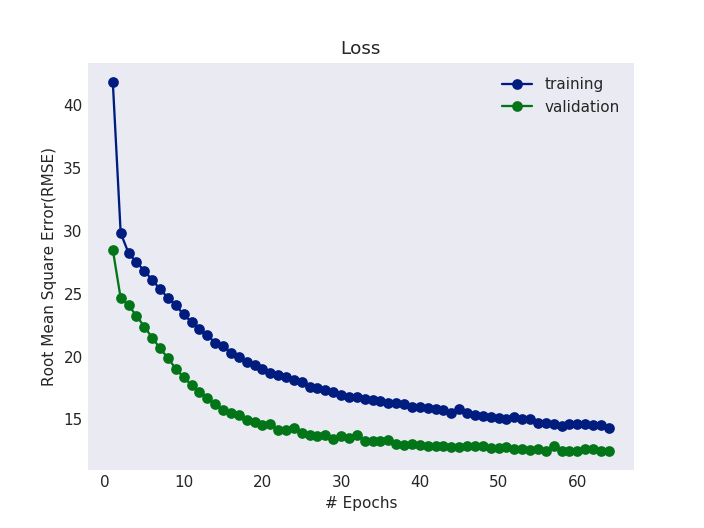

In [10]:
train_model(model, X_train, Y_train, test_fold=3, batch_size=64, max_epochs=100, name='resnet')

377/377 [==============================] - 2s 4ms/step
RMSE for Test data = 14.228022157156753


<IPython.core.display.Javascript object>


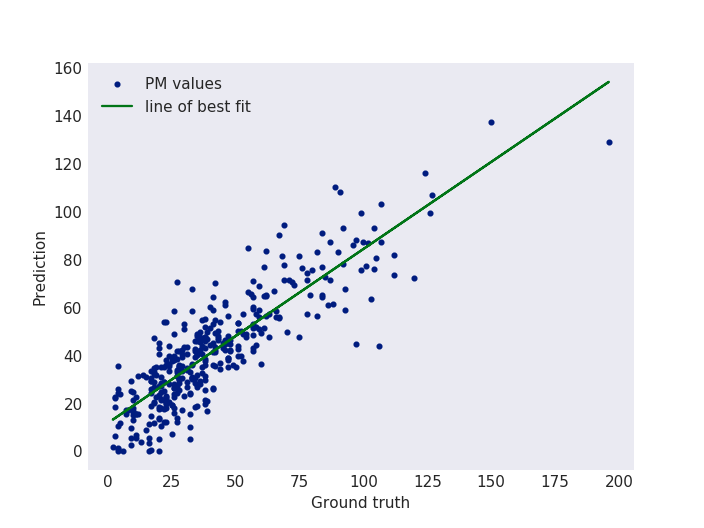

In [11]:
model_path="models/resnet_model3.h5"
evaluate_model(model_path, X_test, Y_test, Z_test, test_fold=3, name='resnet')

### 4th fold as test set

In [10]:
train_model(model, X_train, Y_train, test_fold=4, batch_size=64, max_epochs=100, name='resnet')

Train on 2638 samples, validate on 189 samples


A Jupyter Widget

A Jupyter Widget

Epoch 1/100
2638/2638 [==============================] - 12s 5ms/step - loss: 1678.1930 - val_loss: 1359.9928


A Jupyter Widget

Epoch 2/100
2638/2638 [==============================] - 10s 4ms/step - loss: 832.5129 - val_loss: 1035.6615


A Jupyter Widget

Epoch 3/100
2638/2638 [==============================] - 10s 4ms/step - loss: 745.6381 - val_loss: 966.5051


A Jupyter Widget

Epoch 4/100
2638/2638 [==============================] - 10s 4ms/step - loss: 707.7008 - val_loss: 914.9169


A Jupyter Widget

Epoch 5/100
2638/2638 [==============================] - 10s 4ms/step - loss: 669.7165 - val_loss: 856.7462


A Jupyter Widget

Epoch 6/100
2638/2638 [==============================] - 10s 4ms/step - loss: 634.6312 - val_loss: 807.5912


A Jupyter Widget

Epoch 7/100
2638/2638 [==============================] - 10s 4ms/step - loss: 600.5768 - val_loss: 761.0615


A Jupyter Widget

Epoch 8/100
2638/2638 [==============================] - 10s 4ms/step - loss: 564.6446 - val_loss: 718.7174


A Jupyter Widget

Epoch 9/100
2638/2638 [==============================] - 10s 4ms/step - loss: 532.5801 - val_loss: 682.8471


A Jupyter Widget

Epoch 10/100
2638/2638 [==============================] - 10s 4ms/step - loss: 506.2370 - val_loss: 649.3287


A Jupyter Widget

Epoch 11/100
2638/2638 [==============================] - 10s 4ms/step - loss: 480.1639 - val_loss: 617.1729


A Jupyter Widget

Epoch 12/100
2638/2638 [==============================] - 10s 4ms/step - loss: 454.3845 - val_loss: 589.3538


A Jupyter Widget

Epoch 13/100
2638/2638 [==============================] - 10s 4ms/step - loss: 430.4720 - val_loss: 564.8598


A Jupyter Widget

Epoch 14/100
2638/2638 [==============================] - 10s 4ms/step - loss: 410.3952 - val_loss: 542.2595


A Jupyter Widget

Epoch 15/100
2638/2638 [==============================] - 10s 4ms/step - loss: 396.2873 - val_loss: 524.8814


A Jupyter Widget

Epoch 16/100
2638/2638 [==============================] - 10s 4ms/step - loss: 380.2928 - val_loss: 505.3384


A Jupyter Widget

Epoch 17/100
2638/2638 [==============================] - 10s 4ms/step - loss: 363.4917 - val_loss: 491.4548


A Jupyter Widget

Epoch 18/100
2638/2638 [==============================] - 10s 4ms/step - loss: 351.7328 - val_loss: 477.9856


A Jupyter Widget

Epoch 19/100
2638/2638 [==============================] - 10s 4ms/step - loss: 337.6159 - val_loss: 464.7918


A Jupyter Widget

Epoch 20/100
2638/2638 [==============================] - 10s 4ms/step - loss: 327.8884 - val_loss: 454.3379


A Jupyter Widget

Epoch 21/100
2638/2638 [==============================] - 10s 4ms/step - loss: 326.1560 - val_loss: 443.9340


A Jupyter Widget

Epoch 22/100
2638/2638 [==============================] - 10s 4ms/step - loss: 312.7302 - val_loss: 437.2222


A Jupyter Widget

Epoch 23/100
2638/2638 [==============================] - 10s 4ms/step - loss: 308.4957 - val_loss: 427.4698


A Jupyter Widget

Epoch 24/100
2638/2638 [==============================] - 10s 4ms/step - loss: 295.2905 - val_loss: 420.6211


A Jupyter Widget

Epoch 25/100
2638/2638 [==============================] - 10s 4ms/step - loss: 289.6655 - val_loss: 413.4262


A Jupyter Widget

Epoch 26/100
2638/2638 [==============================] - 10s 4ms/step - loss: 281.9823 - val_loss: 408.0754


A Jupyter Widget

Epoch 27/100
2638/2638 [==============================] - 10s 4ms/step - loss: 278.0791 - val_loss: 400.4263


A Jupyter Widget

Epoch 28/100
2638/2638 [==============================] - 10s 4ms/step - loss: 275.7091 - val_loss: 395.9810


A Jupyter Widget

Epoch 29/100
2638/2638 [==============================] - 10s 4ms/step - loss: 268.9663 - val_loss: 391.6866


A Jupyter Widget

Epoch 30/100
2638/2638 [==============================] - 10s 4ms/step - loss: 264.7340 - val_loss: 386.4303


A Jupyter Widget

Epoch 31/100
2638/2638 [==============================] - 10s 4ms/step - loss: 259.1657 - val_loss: 382.8058


A Jupyter Widget

Epoch 32/100
2638/2638 [==============================] - 10s 4ms/step - loss: 259.2951 - val_loss: 375.0517


A Jupyter Widget

Epoch 33/100
2638/2638 [==============================] - 10s 4ms/step - loss: 257.0086 - val_loss: 379.0315


A Jupyter Widget

Epoch 34/100
2638/2638 [==============================] - 10s 4ms/step - loss: 250.7944 - val_loss: 367.0514


A Jupyter Widget

Epoch 35/100
2638/2638 [==============================] - 10s 4ms/step - loss: 243.0047 - val_loss: 364.6533


A Jupyter Widget

Epoch 36/100
2638/2638 [==============================] - 10s 4ms/step - loss: 248.3293 - val_loss: 360.1305


A Jupyter Widget

Epoch 37/100
2638/2638 [==============================] - 10s 4ms/step - loss: 241.2291 - val_loss: 355.5138


A Jupyter Widget

Epoch 38/100
2638/2638 [==============================] - 10s 4ms/step - loss: 236.2136 - val_loss: 352.0718


A Jupyter Widget

Epoch 39/100
2638/2638 [==============================] - 10s 4ms/step - loss: 236.3271 - val_loss: 349.2062


A Jupyter Widget

Epoch 40/100
2638/2638 [==============================] - 10s 4ms/step - loss: 238.0034 - val_loss: 346.2494


A Jupyter Widget

Epoch 41/100
2638/2638 [==============================] - 10s 4ms/step - loss: 232.0000 - val_loss: 344.5376


A Jupyter Widget

Epoch 42/100
2638/2638 [==============================] - 10s 4ms/step - loss: 225.3183 - val_loss: 341.8267


A Jupyter Widget

Epoch 43/100
2638/2638 [==============================] - 10s 4ms/step - loss: 223.8411 - val_loss: 337.0783


A Jupyter Widget

Epoch 44/100
2638/2638 [==============================] - 10s 4ms/step - loss: 220.9878 - val_loss: 334.1674


A Jupyter Widget

Epoch 45/100
2638/2638 [==============================] - 10s 4ms/step - loss: 221.3623 - val_loss: 331.9409


A Jupyter Widget

Epoch 46/100
2638/2638 [==============================] - 10s 4ms/step - loss: 219.3463 - val_loss: 329.8382


A Jupyter Widget

Epoch 47/100
2638/2638 [==============================] - 10s 4ms/step - loss: 216.1341 - val_loss: 325.9177


A Jupyter Widget

Epoch 48/100
2638/2638 [==============================] - 10s 4ms/step - loss: 219.2827 - val_loss: 325.4182


A Jupyter Widget

Epoch 49/100
2638/2638 [==============================] - 10s 4ms/step - loss: 212.5457 - val_loss: 321.6817


A Jupyter Widget

Epoch 50/100
2638/2638 [==============================] - 10s 4ms/step - loss: 209.1818 - val_loss: 320.7180


A Jupyter Widget

Epoch 51/100
2638/2638 [==============================] - 10s 4ms/step - loss: 208.1107 - val_loss: 319.3400


A Jupyter Widget

Epoch 52/100
2638/2638 [==============================] - 10s 4ms/step - loss: 213.0467 - val_loss: 314.9754


A Jupyter Widget

Epoch 53/100
2638/2638 [==============================] - 10s 4ms/step - loss: 207.1947 - val_loss: 314.6889


A Jupyter Widget

Epoch 54/100
2638/2638 [==============================] - 10s 4ms/step - loss: 200.6492 - val_loss: 312.7177


A Jupyter Widget

Epoch 55/100
2638/2638 [==============================] - 10s 4ms/step - loss: 199.3781 - val_loss: 308.2737


A Jupyter Widget

Epoch 56/100
2638/2638 [==============================] - 10s 4ms/step - loss: 199.8866 - val_loss: 307.4581


A Jupyter Widget

Epoch 57/100
2638/2638 [==============================] - 11s 4ms/step - loss: 197.3892 - val_loss: 304.8435


A Jupyter Widget

Epoch 58/100
2638/2638 [==============================] - 10s 4ms/step - loss: 195.4126 - val_loss: 305.7338


A Jupyter Widget

Epoch 59/100
2638/2638 [==============================] - 11s 4ms/step - loss: 195.5463 - val_loss: 301.4846


A Jupyter Widget

Epoch 60/100
2638/2638 [==============================] - 10s 4ms/step - loss: 193.4975 - val_loss: 300.4403


A Jupyter Widget

Epoch 61/100
2638/2638 [==============================] - 9s 4ms/step - loss: 198.3331 - val_loss: 301.4926


A Jupyter Widget

Epoch 62/100
2638/2638 [==============================] - 10s 4ms/step - loss: 198.7973 - val_loss: 296.6122


A Jupyter Widget

Epoch 63/100
2638/2638 [==============================] - 10s 4ms/step - loss: 189.3974 - val_loss: 295.1917


A Jupyter Widget

Epoch 64/100
2638/2638 [==============================] - 10s 4ms/step - loss: 189.8676 - val_loss: 294.7876


A Jupyter Widget

Epoch 65/100
2638/2638 [==============================] - 10s 4ms/step - loss: 191.1115 - val_loss: 292.0159


A Jupyter Widget

Epoch 66/100
2638/2638 [==============================] - 10s 4ms/step - loss: 184.9347 - val_loss: 295.4313


A Jupyter Widget

Epoch 67/100
2638/2638 [==============================] - 10s 4ms/step - loss: 188.9636 - val_loss: 290.5424


A Jupyter Widget

Epoch 68/100
2638/2638 [==============================] - 10s 4ms/step - loss: 185.4888 - val_loss: 288.2014


A Jupyter Widget

Epoch 69/100
2638/2638 [==============================] - 10s 4ms/step - loss: 183.0575 - val_loss: 287.1664


A Jupyter Widget

Epoch 70/100
2638/2638 [==============================] - 10s 4ms/step - loss: 187.3275 - val_loss: 286.9862


A Jupyter Widget

Epoch 71/100
2638/2638 [==============================] - 10s 4ms/step - loss: 179.2026 - val_loss: 289.1369


A Jupyter Widget

Epoch 72/100
2638/2638 [==============================] - 10s 4ms/step - loss: 180.4075 - val_loss: 283.5759


A Jupyter Widget

Epoch 73/100
2638/2638 [==============================] - 9s 4ms/step - loss: 182.3517 - val_loss: 287.2368


A Jupyter Widget

Epoch 74/100
2638/2638 [==============================] - 10s 4ms/step - loss: 181.6011 - val_loss: 283.4061


A Jupyter Widget

Epoch 75/100
2638/2638 [==============================] - 10s 4ms/step - loss: 181.7053 - val_loss: 281.9923


A Jupyter Widget

Epoch 76/100
2638/2638 [==============================] - 10s 4ms/step - loss: 183.6586 - val_loss: 279.0917


A Jupyter Widget

Epoch 77/100
2638/2638 [==============================] - 10s 4ms/step - loss: 177.1945 - val_loss: 278.5424


A Jupyter Widget

Epoch 78/100
2638/2638 [==============================] - 10s 4ms/step - loss: 176.8307 - val_loss: 279.6041


A Jupyter Widget

Epoch 79/100
2638/2638 [==============================] - 10s 4ms/step - loss: 175.3373 - val_loss: 279.1773


A Jupyter Widget

Epoch 80/100
2638/2638 [==============================] - 11s 4ms/step - loss: 174.8137 - val_loss: 276.9032


A Jupyter Widget

Epoch 81/100
2638/2638 [==============================] - 10s 4ms/step - loss: 173.3031 - val_loss: 280.9424


A Jupyter Widget

Epoch 82/100
2638/2638 [==============================] - 10s 4ms/step - loss: 180.3179 - val_loss: 273.7832


A Jupyter Widget

Epoch 83/100
2638/2638 [==============================] - 10s 4ms/step - loss: 177.1053 - val_loss: 273.4346


A Jupyter Widget

Epoch 84/100
2638/2638 [==============================] - 10s 4ms/step - loss: 174.3588 - val_loss: 273.5385


A Jupyter Widget

Epoch 85/100
2638/2638 [==============================] - 10s 4ms/step - loss: 168.0480 - val_loss: 272.6406


A Jupyter Widget

Epoch 86/100
2638/2638 [==============================] - 10s 4ms/step - loss: 170.3465 - val_loss: 271.7353


A Jupyter Widget

Epoch 87/100
2638/2638 [==============================] - 10s 4ms/step - loss: 170.1295 - val_loss: 273.9588


A Jupyter Widget

Epoch 88/100
2638/2638 [==============================] - 10s 4ms/step - loss: 169.5148 - val_loss: 271.2557


A Jupyter Widget

Epoch 89/100
2638/2638 [==============================] - 10s 4ms/step - loss: 165.1606 - val_loss: 269.8947


A Jupyter Widget

Epoch 90/100
2638/2638 [==============================] - 9s 4ms/step - loss: 169.1816 - val_loss: 270.0819


A Jupyter Widget

Epoch 91/100
2638/2638 [==============================] - 10s 4ms/step - loss: 163.5176 - val_loss: 266.4225


A Jupyter Widget

Epoch 92/100
2638/2638 [==============================] - 10s 4ms/step - loss: 163.6307 - val_loss: 269.7376


A Jupyter Widget

Epoch 93/100
2638/2638 [==============================] - 10s 4ms/step - loss: 165.5714 - val_loss: 265.6961


A Jupyter Widget

Epoch 94/100
2638/2638 [==============================] - 10s 4ms/step - loss: 159.8456 - val_loss: 264.1940


A Jupyter Widget

Epoch 95/100
2638/2638 [==============================] - 10s 4ms/step - loss: 167.8154 - val_loss: 266.6122


A Jupyter Widget

Epoch 96/100
2638/2638 [==============================] - 10s 4ms/step - loss: 159.9849 - val_loss: 263.4174


A Jupyter Widget

Epoch 97/100
2638/2638 [==============================] - 10s 4ms/step - loss: 166.7091 - val_loss: 269.1441


A Jupyter Widget

Epoch 98/100
2638/2638 [==============================] - 10s 4ms/step - loss: 160.4561 - val_loss: 263.3139


A Jupyter Widget

Epoch 99/100
2638/2638 [==============================] - 10s 4ms/step - loss: 163.2894 - val_loss: 262.1193


A Jupyter Widget

Epoch 100/100
2638/2638 [==============================] - 10s 4ms/step - loss: 165.0107 - val_loss: 262.2597



<IPython.core.display.Javascript object>

In [11]:
model_path="models/resnet_model4.h5"
evaluate_model(model_path, X_test, Y_test, Z_test, test_fold=4, name='resnet')

377/377 [==============================] - 2s 4ms/step
RMSE for Test data = 14.099977368393454


<IPython.core.display.Javascript object>

### Fifth fold as test set

In [10]:
train_model(model, X_train, Y_train, test_fold=5, batch_size=64, max_epochs=100, name='resnet')

Train on 2638 samples, validate on 189 samples


A Jupyter Widget

A Jupyter Widget

Epoch 1/100
2638/2638 [==============================] - 12s 5ms/step - loss: 1775.2579 - val_loss: 933.3104


A Jupyter Widget

Epoch 2/100
2638/2638 [==============================] - 10s 4ms/step - loss: 881.5558 - val_loss: 737.2984


A Jupyter Widget

Epoch 3/100
2638/2638 [==============================] - 10s 4ms/step - loss: 781.6614 - val_loss: 711.3388


A Jupyter Widget

Epoch 4/100
2638/2638 [==============================] - 10s 4ms/step - loss: 745.3211 - val_loss: 680.6246


A Jupyter Widget

Epoch 5/100
2638/2638 [==============================] - 10s 4ms/step - loss: 706.0979 - val_loss: 635.4115


A Jupyter Widget

Epoch 6/100
2638/2638 [==============================] - 10s 4ms/step - loss: 667.0336 - val_loss: 595.7702


A Jupyter Widget

Epoch 7/100
2638/2638 [==============================] - 10s 4ms/step - loss: 631.8333 - val_loss: 556.3547


A Jupyter Widget

Epoch 8/100
2638/2638 [==============================] - 10s 4ms/step - loss: 598.6850 - val_loss: 522.4869


A Jupyter Widget

Epoch 9/100
2638/2638 [==============================] - 10s 4ms/step - loss: 564.9782 - val_loss: 493.2208


A Jupyter Widget

Epoch 10/100
2638/2638 [==============================] - 10s 4ms/step - loss: 539.0180 - val_loss: 468.0807


A Jupyter Widget

Epoch 11/100
2638/2638 [==============================] - 10s 4ms/step - loss: 507.9768 - val_loss: 438.7315


A Jupyter Widget

Epoch 12/100
2638/2638 [==============================] - 10s 4ms/step - loss: 486.3780 - val_loss: 417.1900


A Jupyter Widget

Epoch 13/100
2638/2638 [==============================] - 10s 4ms/step - loss: 459.5085 - val_loss: 405.1360


A Jupyter Widget

Epoch 14/100
2638/2638 [==============================] - 10s 4ms/step - loss: 438.9181 - val_loss: 381.4548


A Jupyter Widget

Epoch 15/100
2638/2638 [==============================] - 10s 4ms/step - loss: 422.0636 - val_loss: 367.6010


A Jupyter Widget

Epoch 16/100
2638/2638 [==============================] - 10s 4ms/step - loss: 403.6869 - val_loss: 357.0890


A Jupyter Widget

Epoch 17/100
2638/2638 [==============================] - 10s 4ms/step - loss: 390.5484 - val_loss: 347.2856


A Jupyter Widget

Epoch 18/100
2638/2638 [==============================] - 10s 4ms/step - loss: 380.7426 - val_loss: 333.5937


A Jupyter Widget

Epoch 19/100
2638/2638 [==============================] - 10s 4ms/step - loss: 362.4328 - val_loss: 320.5577


A Jupyter Widget

Epoch 20/100
2638/2638 [==============================] - 10s 4ms/step - loss: 352.4594 - val_loss: 314.1545


A Jupyter Widget

Epoch 21/100
2638/2638 [==============================] - 10s 4ms/step - loss: 343.0736 - val_loss: 311.2964


A Jupyter Widget

Epoch 22/100
2638/2638 [==============================] - 10s 4ms/step - loss: 335.9456 - val_loss: 305.3188


A Jupyter Widget

Epoch 23/100
2638/2638 [==============================] - 10s 4ms/step - loss: 327.4626 - val_loss: 290.4879


A Jupyter Widget

Epoch 24/100
2638/2638 [==============================] - 9s 4ms/step - loss: 316.4697 - val_loss: 296.2944


A Jupyter Widget

Epoch 25/100
2638/2638 [==============================] - 10s 4ms/step - loss: 311.3280 - val_loss: 280.3004


A Jupyter Widget

Epoch 26/100
2638/2638 [==============================] - 10s 4ms/step - loss: 307.9926 - val_loss: 275.1831


A Jupyter Widget

Epoch 27/100
2638/2638 [==============================] - 9s 4ms/step - loss: 299.5574 - val_loss: 276.3151


A Jupyter Widget

Epoch 28/100
2638/2638 [==============================] - 10s 4ms/step - loss: 293.2170 - val_loss: 273.9870


A Jupyter Widget

Epoch 29/100
2638/2638 [==============================] - 10s 4ms/step - loss: 285.3311 - val_loss: 268.4965


A Jupyter Widget

Epoch 30/100
2638/2638 [==============================] - 10s 4ms/step - loss: 289.0589 - val_loss: 267.1382


A Jupyter Widget

Epoch 31/100
2638/2638 [==============================] - 10s 4ms/step - loss: 281.1269 - val_loss: 254.8414


A Jupyter Widget

Epoch 32/100
2638/2638 [==============================] - 10s 4ms/step - loss: 277.8438 - val_loss: 261.1869


A Jupyter Widget

Epoch 33/100
2638/2638 [==============================] - 10s 4ms/step - loss: 270.3027 - val_loss: 256.7811


A Jupyter Widget

Epoch 34/100
2638/2638 [==============================] - 10s 4ms/step - loss: 266.5287 - val_loss: 250.4092


A Jupyter Widget

Epoch 35/100
2638/2638 [==============================] - 10s 4ms/step - loss: 268.1976 - val_loss: 242.7425


A Jupyter Widget

Epoch 36/100
2638/2638 [==============================] - 10s 4ms/step - loss: 261.6113 - val_loss: 251.4079


A Jupyter Widget

Epoch 37/100
2638/2638 [==============================] - 9s 4ms/step - loss: 261.6839 - val_loss: 244.9797


A Jupyter Widget

Epoch 38/100
2638/2638 [==============================] - 10s 4ms/step - loss: 254.3062 - val_loss: 234.3221


A Jupyter Widget

Epoch 39/100
2638/2638 [==============================] - 10s 4ms/step - loss: 250.7330 - val_loss: 236.9195


A Jupyter Widget

Epoch 40/100
2638/2638 [==============================] - 10s 4ms/step - loss: 248.9359 - val_loss: 230.0976


A Jupyter Widget

Epoch 41/100
2638/2638 [==============================] - 9s 4ms/step - loss: 247.0409 - val_loss: 236.1905


A Jupyter Widget

Epoch 42/100
2638/2638 [==============================] - 10s 4ms/step - loss: 244.5443 - val_loss: 225.7182


A Jupyter Widget

Epoch 43/100
2638/2638 [==============================] - 10s 4ms/step - loss: 239.5183 - val_loss: 224.4098


A Jupyter Widget

Epoch 44/100
2638/2638 [==============================] - 10s 4ms/step - loss: 242.6395 - val_loss: 219.6903


A Jupyter Widget

Epoch 45/100
2638/2638 [==============================] - 10s 4ms/step - loss: 229.8389 - val_loss: 227.2790


A Jupyter Widget

Epoch 46/100
2638/2638 [==============================] - 10s 4ms/step - loss: 232.1033 - val_loss: 219.2172


A Jupyter Widget

Epoch 47/100
2638/2638 [==============================] - 10s 4ms/step - loss: 230.9539 - val_loss: 213.2186


A Jupyter Widget

Epoch 48/100
2638/2638 [==============================] - 10s 4ms/step - loss: 229.7143 - val_loss: 219.1087


A Jupyter Widget

Epoch 49/100
2638/2638 [==============================] - 10s 4ms/step - loss: 230.7542 - val_loss: 220.1400


A Jupyter Widget

Epoch 50/100
2638/2638 [==============================] - 10s 4ms/step - loss: 229.2798 - val_loss: 204.9243


A Jupyter Widget

Epoch 51/100
2638/2638 [==============================] - 10s 4ms/step - loss: 227.8889 - val_loss: 205.8390


A Jupyter Widget

Epoch 52/100
2638/2638 [==============================] - 10s 4ms/step - loss: 226.1139 - val_loss: 211.1542


A Jupyter Widget

Epoch 53/100
2638/2638 [==============================] - 10s 4ms/step - loss: 220.4280 - val_loss: 209.8676


A Jupyter Widget

Epoch 54/100
2638/2638 [==============================] - 10s 4ms/step - loss: 221.4652 - val_loss: 200.6421


A Jupyter Widget

Epoch 55/100
2638/2638 [==============================] - 10s 4ms/step - loss: 216.3303 - val_loss: 199.1916


A Jupyter Widget

Epoch 56/100
2638/2638 [==============================] - 10s 4ms/step - loss: 215.1553 - val_loss: 206.5674


A Jupyter Widget

Epoch 57/100
2638/2638 [==============================] - 10s 4ms/step - loss: 213.0642 - val_loss: 206.2033


A Jupyter Widget

Epoch 58/100
2638/2638 [==============================] - 10s 4ms/step - loss: 213.5252 - val_loss: 199.6486


A Jupyter Widget

Epoch 59/100
2638/2638 [==============================] - 10s 4ms/step - loss: 214.2856 - val_loss: 200.6371


A Jupyter Widget

Epoch 60/100
2638/2638 [==============================] - 10s 4ms/step - loss: 211.9077 - val_loss: 196.1064


A Jupyter Widget

Epoch 61/100
2638/2638 [==============================] - 9s 4ms/step - loss: 209.2706 - val_loss: 205.2419


A Jupyter Widget

Epoch 62/100
2638/2638 [==============================] - 10s 4ms/step - loss: 211.8694 - val_loss: 190.0261


A Jupyter Widget

Epoch 63/100
2638/2638 [==============================] - 10s 4ms/step - loss: 202.1158 - val_loss: 192.2812


A Jupyter Widget

Epoch 64/100
2638/2638 [==============================] - 10s 4ms/step - loss: 208.0922 - val_loss: 191.5056


A Jupyter Widget

Epoch 65/100
2638/2638 [==============================] - 10s 4ms/step - loss: 197.6875 - val_loss: 198.7915


A Jupyter Widget

Epoch 66/100
2638/2638 [==============================] - 10s 4ms/step - loss: 198.3010 - val_loss: 190.2446


A Jupyter Widget

Epoch 67/100
2638/2638 [==============================] - 10s 4ms/step - loss: 201.1145 - val_loss: 187.8744


A Jupyter Widget

Epoch 68/100
2638/2638 [==============================] - 10s 4ms/step - loss: 195.9761 - val_loss: 187.8808


A Jupyter Widget

Epoch 69/100
2638/2638 [==============================] - 10s 4ms/step - loss: 197.7465 - val_loss: 185.2344


A Jupyter Widget

Epoch 70/100
2638/2638 [==============================] - 10s 4ms/step - loss: 199.8513 - val_loss: 182.0989


A Jupyter Widget

Epoch 71/100
2638/2638 [==============================] - 10s 4ms/step - loss: 192.7042 - val_loss: 186.5641


A Jupyter Widget

Epoch 72/100
2638/2638 [==============================] - 10s 4ms/step - loss: 195.3332 - val_loss: 183.6122


A Jupyter Widget

Epoch 73/100
2638/2638 [==============================] - 10s 4ms/step - loss: 197.6627 - val_loss: 177.8961


A Jupyter Widget

Epoch 74/100
2638/2638 [==============================] - 10s 4ms/step - loss: 196.1056 - val_loss: 176.8742


A Jupyter Widget

Epoch 75/100
2638/2638 [==============================] - 10s 4ms/step - loss: 189.8286 - val_loss: 191.1848


A Jupyter Widget

Epoch 76/100
2638/2638 [==============================] - 10s 4ms/step - loss: 194.2119 - val_loss: 182.2220


A Jupyter Widget

Epoch 77/100
2638/2638 [==============================] - 10s 4ms/step - loss: 189.9758 - val_loss: 185.8448


A Jupyter Widget

Epoch 78/100
2638/2638 [==============================] - 10s 4ms/step - loss: 182.4915 - val_loss: 174.0461


A Jupyter Widget

Epoch 79/100
2638/2638 [==============================] - 10s 4ms/step - loss: 186.0230 - val_loss: 182.5836


A Jupyter Widget

Epoch 80/100
2638/2638 [==============================] - 10s 4ms/step - loss: 184.2418 - val_loss: 176.7317


A Jupyter Widget

Epoch 81/100
2638/2638 [==============================] - 10s 4ms/step - loss: 185.6042 - val_loss: 174.3207


A Jupyter Widget

Epoch 82/100
2638/2638 [==============================] - 10s 4ms/step - loss: 184.6126 - val_loss: 176.7774


A Jupyter Widget

Epoch 83/100
2638/2638 [==============================] - 10s 4ms/step - loss: 185.4042 - val_loss: 175.1561


A Jupyter Widget

Epoch 84/100
2624/2638 [============================>.] - ETA: 0s - loss: 182.0192Epoch 00084: val_loss did not improve

Epoch 00084: reducing learning rate to 0.000800000037997961.
2638/2638 [==============================] - 10s 4ms/step - loss: 182.7079 - val_loss: 184.4265
Epoch 00084: early stopping



<IPython.core.display.Javascript object>

377/377 [==============================] - 2s 5ms/step
RMSE for Test data = 13.875886452377328


<IPython.core.display.Javascript object>


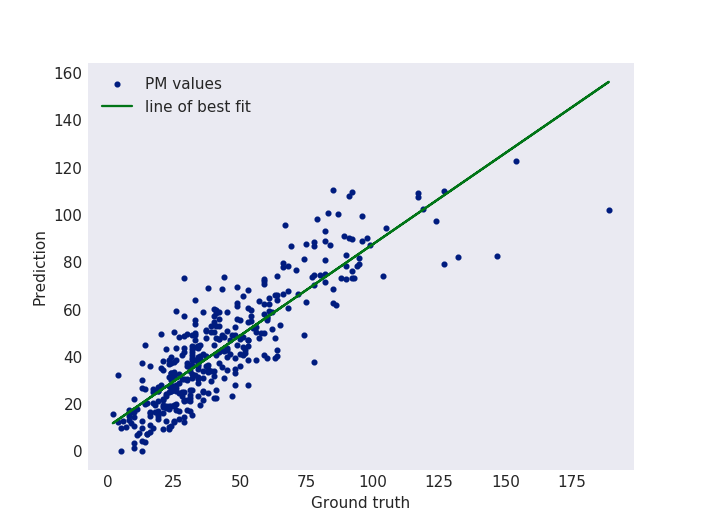

In [19]:
model_path="models/resnet_model5.h5"
evaluate_model(model_path, X_test, Y_test, Z_test, test_fold=5, name='resnet')

### Result

In [14]:
result_x=[]
result_y=[]
result_z=[]
name='resnet'
for i in range(5):
    eval_data=np.load('eval/{}_eval_data{}.npz'.format(name,i+1))
    for m in range(len(eval_data['x'])):
                   result_x.append(eval_data['x'][m])
                   result_y.append(eval_data['y'][m])
                   result_z.append(eval_data['z'][m])

result_x=np.array(result_x)
result_y=np.array(result_y)
result_z=np.array(result_z)

result = open('result_resnet50.csv', 'w')
result.write('Image_Name,Original_PM,Predicted_PM\n')
for i in range(len(result_x)):
        result.write('{},{},{:.2f}\n'.format(result_z[i], 
                                                     result_x[i], 
                                                     result_y[i]))
result.close()

In [15]:
def plot_result(x, y):
    m, b = np.polyfit(x, y, 1)
    plt.figure()
    plt.plot(x, y, '.', label="PM values")
    plt.plot(x, m*x + b, '-', label="Line of best fit")
    plt.legend(loc='upper left')
    plt.ylabel('Prediction')
    plt.xlabel('Ground truth')
    plt.grid(linestyle="--")
    plt.show()

def rmse(x,y):
    return np.sqrt(np.mean(np.square(x-y)))
       

def r_squared(x, y):
    SSE=np.sum(np.square(x-y))
    SST=np.sum(np.square(x - np.mean(x)))
    r_squared = 1-(SSE/SST)
    return r_squared

In [16]:
print("RMS Error = {:.3f}".format(rmse(result_x, result_y)))
print("R squared  = {:.3f}".format(r_squared(result_x, result_y)))
print("=================")
#plot_result(result_x, result_y)

RMS Error = 14.222
R squared  = 0.745


In [17]:
result_df=pd.read_csv('result_resnet50.csv')
#print(result_df.describe())
result_df.head()

Image_Name  Original_PM  Predicted_PM
0  201406091045.jpg         38.0         42.56
1  201405211400.jpg        125.0        115.91
2  201406291115.jpg         84.0         96.39
3  201405181100.jpg         32.0         28.98
4  201405061200.jpg         28.0         33.71

<IPython.core.display.Javascript object>


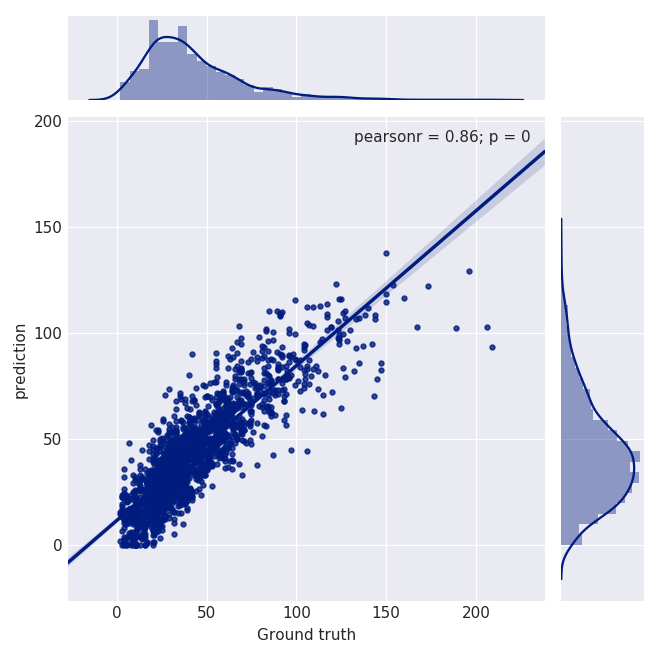

In [18]:
sns.jointplot(data=result_df, x='Original_PM', y='Predicted_PM', kind='reg', scatter_kws={"s": 10}).set_axis_labels("Ground truth", "prediction")

<IPython.core.display.Javascript object>


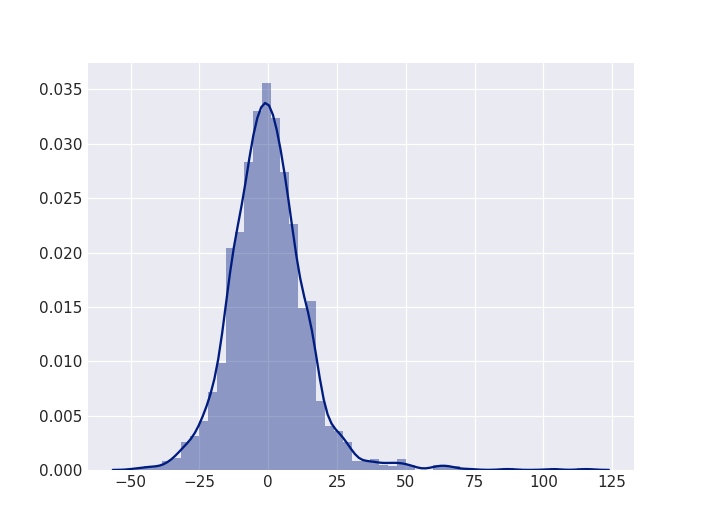

In [20]:
plt.figure()
sns.distplot(result_df['Original_PM']-result_df['Predicted_PM'])

In [21]:
top_5_index=(result_df['Original_PM'] - result_df['Predicted_PM']).abs().nlargest(5).index.values
num_images=4

#Creating subplots of images from the dataset
fig=plt.figure()
for i in range(num_images):
    img=Image.open("images/{}".format(result_df["Image_Name"].values[top_5_index[i]]))
    ax=fig.add_subplot(math.ceil(num_images/2),2,i+1)
    ax.imshow(img)
    ax.set_title('actual={:0.2f} \nprediction={:0.2f}'.format(result_df['Original_PM'].values[top_5_index[i]], 
                                                     result_df['Predicted_PM'].values[top_5_index[i]]))
    ax.set_axis_off()
#automatically adjusts subplot params so that the subplot(s) fits in to the figure area.
fig.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


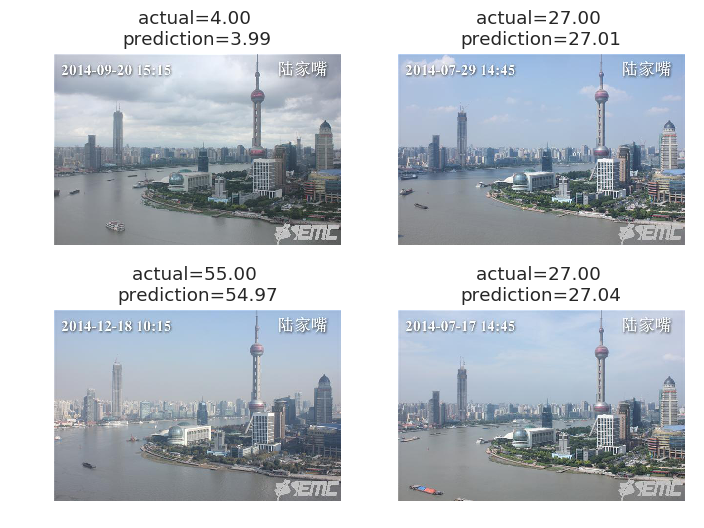

In [22]:
top_5_index=(result_df['Original_PM'] - result_df['Predicted_PM']).abs().nsmallest(5).index.values
num_images=4
#Creating subplots of images from the dataset
fig=plt.figure()
for i in range(num_images):
    img=Image.open("images/{}".format(result_df["Image_Name"].values[top_5_index[i]]))
    ax=fig.add_subplot(math.ceil(num_images/2),2,i+1)
    ax.imshow(img)
    ax.set_title('actual={:0.2f} \nprediction={:0.2f}'.format(result_df['Original_PM'].values[top_5_index[i]], 
                                                     result_df['Predicted_PM'].values[top_5_index[i]]))
    ax.set_axis_off()

fig.tight_layout()